Source: https://github.com/vectorkoz/economic-presidential.git

The goal of this project is to explore the relationship between economic indicators and results of presidential elections in the United States. Political pundits have long stated that the economy has a great influence over the election results, so I became intrested in trying to quantify this relationship. Obviously, creating a model that would accurately predict the results of a presidential election would be like proving the Riemann hypothesis or solving the P vs. NP problem, but unfortunately, many factors that probably influence the results are not quantifiable, such as the personal qualities of a candidate.

Therefore, this project is focused on interpretation. Many features are constructed and presented to linear regression models, then the best model is chosen, and the features that are relevant in that model are shown.

# About the data

The data for the U.S. presidential elections from 1976 to 2020 is taken from here https://doi.org/10.7910/DVN/42MVDX. 

This dataset contains election results for every U.S. state and District of Columbia in every presidential election from 1976 to 2020. Election reslts contain the amount of votes for each candidate in a state, plus write-in votes, plus other miscellaneous votes, and vote totals. The data was cleaned and data on votes for candidates other than the main candidates for Democratic and Republican parties was deleted in the file presid_cleaning.ipynb.

As for feature engineering, 8 features from the data were constructed for every pair of year and state values:
1) d_percent : number of votes for the Democratic party candidate divided by the total number of votes
2) r_percent : same feature as d_percent, only for the Republican candidate
3) dr_percent : equals d_percent-r_percent, if positive, then the Democratic candidate won the election, if negative - the Republican candidate.
4) dr_swing : equals the dr_percent value minus the dr_percent value for the same state, but in the previous election, i.e. 4 years before. Shows the change in the voting pattern.
5) d_percent_vs_national,
6) r_percent_vs_national,
7) dr_percent_vs_national,
8) dr_swing_vs_national - values 5-8 are the values 1-4 minus their respective values, calculated for the whole country.

Since the features dr_swing and dr_swing_vs_national require knowledge of the previous election results, at the end the features were constructed for the elections from 1980 to 2020.

The economic data was taken from the U.S. Bureau of Economic Analysis, specifically the section 'State Personal Income: Revised estimates for 2020' at https://apps.bea.gov/regional/histdata/releases/0921spi/index.cfm . 

This resource contains multitude of various economic features calculated for each U.S. state and territory and for the whole U.S. for each year from the start of relevant data gathering up to 2020. However, many of them have been calculated in different ways over the years, and therefore are not usable for this analysis. Only features from the datasets 'sainc30', 'sainc35', 'sainc4', and 'sainc50' have been used. Each dataset has been processed and cleaned in a separate notebook of the same name. Only those economic indicators with no missing values and no zero or negative values for the necessary years were chosen.

Out of each economic indicator, 4 features for the project were created:
1) 4ych_ : equals the current value (value during the election year) divided by the value during the year of the previous election (4 years previously),
2) 1ych_ : similar to 4ych_, but showing the change from 1 year previously
3) vn_ : equals the current value for a state divided by the current value for the whole U.S.
4) vn_4ych_ : equals the 4ych_ value for a state minus the 4ych_ value for the whole U.S.

All of these values are relative, and show the current value compared to either the national value or the value in the previous years.

Also, 6 features describing what party won the last and the second last national presidential election, as well as whether the incumbent president was running for the reelection.

Overall, 282 features and 8 potential target variables were created.

# Objectives

The goal of this project is interpretation - dicovering meaningful connections between features and the target variables, while using linear regression. For each of the 8 target variables, three models are used: plain linear regression, Lasso and Ridge. Best version of Lasso and Ridge are found using cross-validated grid search. Then, the features that are used in the best model overall are chosen and their correlation with the targets analysed.

# d_percent

Importing libraries, reading and looking at the data

In [1]:
# Surpress warnings:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

import numpy as np
import pandas as pd

import seaborn as sns 
import matplotlib.pylab as plt
%matplotlib inline

from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import r2_score 
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, median_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA

In [2]:
data=pd.read_csv('data/data.csv')
data.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 561 entries, 0 to 560
Data columns (total 293 columns):
 #    Column                                                                                                 Dtype  
---   ------                                                                                                 -----  
 0    fips                                                                                                   int64  
 1    state                                                                                                  object 
 2    year                                                                                                   int64  
 3    4ych_Personal dividend income, Millions of dollars                                                     float64
 4    1ych_Personal dividend income, Millions of dollars                                                     float64
 5    vn_Personal dividend income, Millions of dollars                     

In [3]:
data.head()

fips       state  year  4ych_Personal dividend income, Millions of dollars  \
0     1     Alabama  1980                                           1.671870    
1     2      Alaska  1980                                           1.772487    
2     4     Arizona  1980                                           1.912813    
3     5    Arkansas  1980                                           1.700811    
4     6  California  1980                                           1.723773    

   1ych_Personal dividend income, Millions of dollars  \
0                                           1.088667    
1                                           1.257036    
2                                           1.141725    
3                                           1.097513    
4                                           1.146635    

   vn_Personal dividend income, Millions of dollars  \
0                                          0.009040   
1                                          0.001047   
2                                          0.013512   
3                                          0.005243   
4                                          0.115633   

   vn_4ych_Personal dividend income, Millions of dollars  \
0                                           0.030317       
1                                           0.130933       
2                                           0.271259       
3                                           0.059257       
4                                           0.082219       

   4ych_Personal interest income, Millions of dollars  \
0                                           1.892266    
1                                           1.635354    
2                                           1.989992    
3                                           1.982168    
4                                           1.894359    

   1ych_Personal interest income, Millions of dollars  \
0                                           1.240325    
1                                           1.125869    
2                                           1.247489    
3                                           1.265285    
4                                           1.227591    

   vn_Personal interest income, Millions of dollars  ...  d_winner_4y_ago  \
0                                          0.012106  ...                1   
1                                          0.002448  ...                1   
2                                          0.014313  ...                1   
3                                          0.007698  ...                1   
4                                          0.128728  ...                1   

   r_winner_4y_ago  d_winner_8y_ago  r_winner_8y_ago  incumbent_running  \
0                0                0                1                  1   
1                0                0                1                  1   
2                0                0                1                  1   
3                0                0                1                  1   
4                0                0                1                  1   

   incumbent_not_running  d_percent_vs_national  r_percent_vs_national  \
0                      0               6.428929              -2.001751   
1                      0             -14.612029               3.596326   
2                      0             -12.775247               9.856978   
3                      0               6.502700              -2.617598   
4                      0              -5.100493               1.945632   

   dr_percent_vs_national  dr_swing_vs_national  
0                8.430679             -2.622846  
1              -18.208354              6.101963  
2              -22.632224             -4.007194  
3                9.120299            -18.878220  
4               -7.046126             -3.193760  

[5 rows x 293 columns]

In [4]:
data.year.unique()

array([1980, 1984, 1988, 1992, 1996, 2000, 2004, 2008, 2012, 2016, 2020],
      dtype=int64)

These are the years for which we have the data. Let's use the 2020 as solely the test data. It won't be used for fitting a model at any time, only for evaluating model performance.

In [5]:
#data.drop(columns=[''])
test_data=data[data.year==2020].drop(columns=['fips','state','year'])
train_data=data[data.year!=2020].drop(columns=['fips','state','year'])

Get the list of all target columns in the dataset. 

In [6]:
columns_to_predict=train_data.columns[-14:-10].to_list()
columns_to_predict.extend(data.columns[-4:].to_list())
columns_to_predict

['d_percent',
 'r_percent',
 'dr_percent',
 'dr_swing',
 'd_percent_vs_national',
 'r_percent_vs_national',
 'dr_percent_vs_national',
 'dr_swing_vs_national']

In [7]:
df=train_data.copy()
df_2020=test_data.copy()

Starting the analysis with the d_percent target. It shows the percent of the Democratic vote relative to the total number of votes for every pair of year and state values.

In [8]:
y_col='d_percent'

In [9]:
X=df.drop(columns=columns_to_predict)
y=df[y_col]
X_2020=df_2020.drop(columns=columns_to_predict)
y_2020=df_2020[y_col]

Looking at the distribution of the target.

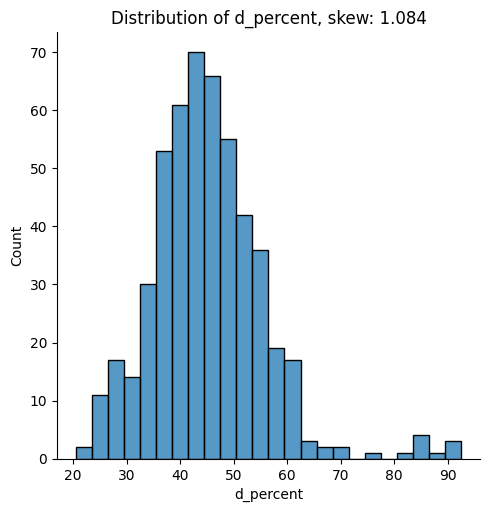

In [10]:
sns.displot(y).set(title='Distribution of '+y_col+', skew: '+str(y.skew())[:5])

The target is heavily skewed, which can harm the predictive abilities of the model. However, since the project objective is feature selection based on linear regression, I decided not to apply any non-linear transormations to the targets.

Making a train_test_split of the test data. This same split will be used to build linear models and example Lasso and Ridge models, primarily to compare the error between the test set constructed from the 1980-2016 data, and the error on the 2020 data.

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.1, random_state=42)
print("number of test samples :", X_test.shape[0])
print("number of training samples:",X_train.shape[0])

number of test samples : 51
number of training samples: 459


Creating a plain linear regression model and evaluating it on the test data as well as the 2020 data. The main score metric used throughout this project is median absolute error - how large is the absolute value of the error in the median case.

In [12]:
lm = LinearRegression()
lm.fit(X_train, y_train)
predicted = lm.predict(X_test)
print("Linear R^2 on training  data ",lm.score(X_train, y_train))
print("Linear R^2 on testing data ",lm.score(X_test,y_test))


Linear R^2 on training  data  0.8923508814881373
Linear R^2 on testing data  0.36998083967680595


In [13]:
print("Linear Median error on testing data ",median_absolute_error(y_true=y_test, y_pred=predicted))

Linear Median error on testing data  4.275568299574971


In [14]:
print("Linear R^2 on 2020 data ",lm.score(X_2020,y_2020))
print("Linear Median error on 2020 data ",median_absolute_error(y_true=y_2020, y_pred=lm.predict(X_2020)))

Linear R^2 on 2020 data  -18583826.65085362
Linear Median error on 2020 data  15783.787938962276


Plain linear regression makes a relatively adequate prediction on the test set, but it fails completely and leads to wild values on the 2020 set with errors in the thousands, while the value of d_percent is supposed to be within 0-100. It's not surprising that this model has overfit - the assumption of multicollinearity clearly doesn't hold in the this case. Therefore, plain linear regression model is not useful for this analysis.

Building a lasso model with alpha=1 using polynomial scaled features of degree 2.

In [15]:
Input=[ ('polynomial', PolynomialFeatures(include_bias=False,degree=2)),('ss',StandardScaler() ), ('model',Lasso(alpha=1, tol = 0.3))]
las_pipe = Pipeline(Input)

In [16]:
las_pipe.fit(X_train, y_train)
las_pred=las_pipe.predict(X_test)
print("LASSO R^2 on training  data ",las_pipe.score(X_train, y_train))
print("LASSO R^2 on testing data ",las_pipe.score(X_test,y_test))

LASSO R^2 on training  data  0.6501256421277044
LASSO R^2 on testing data  0.4848610593903303


In [17]:
print("LASSO Median error on testing data ",median_absolute_error(y_true=y_test, y_pred=las_pred))

LASSO Median error on testing data  3.964843366829065


In [18]:
print("LASSO R^2 on 2020 data ",las_pipe.score(X_2020,y_2020))
print("LASSO Median error on 2020 data ",median_absolute_error(y_true=y_2020, y_pred=las_pipe.predict(X_2020)))

LASSO R^2 on 2020 data  0.37229826886203987
LASSO Median error on 2020 data  6.701220822355893


Using the same train_test_split, Lasso produces a realistic prediction, unlike plain linear model. 
Let's try to train the same model using all the 1980-2016 data.

In [19]:
las_pipe.fit(X, y)

Pipeline(steps=[('polynomial', PolynomialFeatures(include_bias=False)),
                ('ss', StandardScaler()), ('model', Lasso(alpha=1, tol=0.3))])

In [20]:
print("R^2 on 2020 data ",las_pipe.score(X_2020,y_2020))
print("Median error on 2020 data ",median_absolute_error(y_true=y_2020, y_pred=las_pipe.predict(X_2020)))

R^2 on 2020 data  -1.0436250792130362
Median error on 2020 data  11.989165304210012


The same model trained on all the data actually produces a worse result. Normally, it shouldn't happen. It shows that I just got lucky with the initial split, and that the whole dataset lacks data to make a really good prediction.

This conclusion is not surprising. In real life when we would try to guess the result of a presidential election in a state, we would take into account what that state is exactly, as well as some features describing the actual candidates. These features are not included in this model, making it impossible to get an accurate prediction. However, in my opinion, it allows to better focus on analysing the impact of the economic features.

Conducting cross validated grid search using a KFold object to pick the best value for the alpha and the polynomial degree.

In [21]:
kf = KFold(shuffle=True, random_state=72018, n_splits=10)

In [22]:
param_grid = {
    "polynomial__degree": [1, 2],
    "model__alpha":[0.01,0.1,1,10, 20]
}

In [23]:
las_search = GridSearchCV(las_pipe, param_grid, n_jobs=2, cv=kf)
las_search.fit(X, y)

GridSearchCV(cv=KFold(n_splits=10, random_state=72018, shuffle=True),
             estimator=Pipeline(steps=[('polynomial',
                                        PolynomialFeatures(include_bias=False)),
                                       ('ss', StandardScaler()),
                                       ('model', Lasso(alpha=1, tol=0.3))]),
             n_jobs=2,
             param_grid={'model__alpha': [0.01, 0.1, 1, 10, 20],
                         'polynomial__degree': [1, 2]})

In [24]:
pd.DataFrame(las_search.cv_results_).sort_values(by='mean_test_score',ascending=False).head()

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
5       0.772792      0.020165         0.032030        0.002942   
4       0.014119      0.004933         0.003181        0.004646   
2       0.014428      0.001241         0.003489        0.000669   
0       0.015787      0.004386         0.003334        0.004327   
3       0.760773      0.039863         0.032292        0.001833   

  param_model__alpha param_polynomial__degree  \
5                  1                        2   
4                  1                        1   
2                0.1                        1   
0               0.01                        1   
3                0.1                        2   

                                            params  split0_test_score  \
5     {'model__alpha': 1, 'polynomial__degree': 2}           0.542050   
4     {'model__alpha': 1, 'polynomial__degree': 1}           0.531329   
2   {'model__alpha': 0.1, 'polynomial__degree': 1}           0.509298   
0  {'model__alpha': 0.01, 'polynomial__degree': 1}           0.506184   
3   {'model__alpha': 0.1, 'polynomial__degree': 2}           0.490405   

   split1_test_score  split2_test_score  split3_test_score  split4_test_score  \
5           0.687964           0.471213           0.583957           0.593357   
4           0.654299           0.399547           0.566031           0.496453   
2           0.699782           0.344481           0.564701           0.539114   
0           0.672522           0.194426           0.572177           0.520535   
3          -1.583080           0.423185           0.690892           0.600295   

   split5_test_score  split6_test_score  split7_test_score  split8_test_score  \
5           0.567296           0.596408           0.346527           0.542038   
4           0.471619           0.530335           0.330167           0.468361   
2           0.371559           0.532422          -0.097395           0.396535   
0           0.309581           0.491762          -0.584279           0.387045   
3           0.588069           0.590386          -0.351786           0.633562   

   split9_test_score  mean_test_score  std_test_score  rank_test_score  
5           0.508835         0.543964        0.085782                1  
4           0.456056         0.490420        0.084756                2  
2           0.467004         0.432750        0.202706                3  
0           0.466604         0.353656        0.337714                4  
3           0.599553         0.268148        0.679954                5

In [25]:
las_cv_pred=las_search.best_estimator_.predict(X_test)
print("Median error on testing data ",median_absolute_error(y_true=y_test, y_pred=las_cv_pred))

Median error on testing data  4.420377781204486


In [26]:
print("R^2 on 2020 data ",las_search.best_estimator_.score(X_2020,y_2020))
print("Median error on 2020 data ",median_absolute_error(y_true=y_2020, y_pred=las_search.best_estimator_.predict(X_2020)))

R^2 on 2020 data  -1.0436250792130362
Median error on 2020 data  11.989165304210012


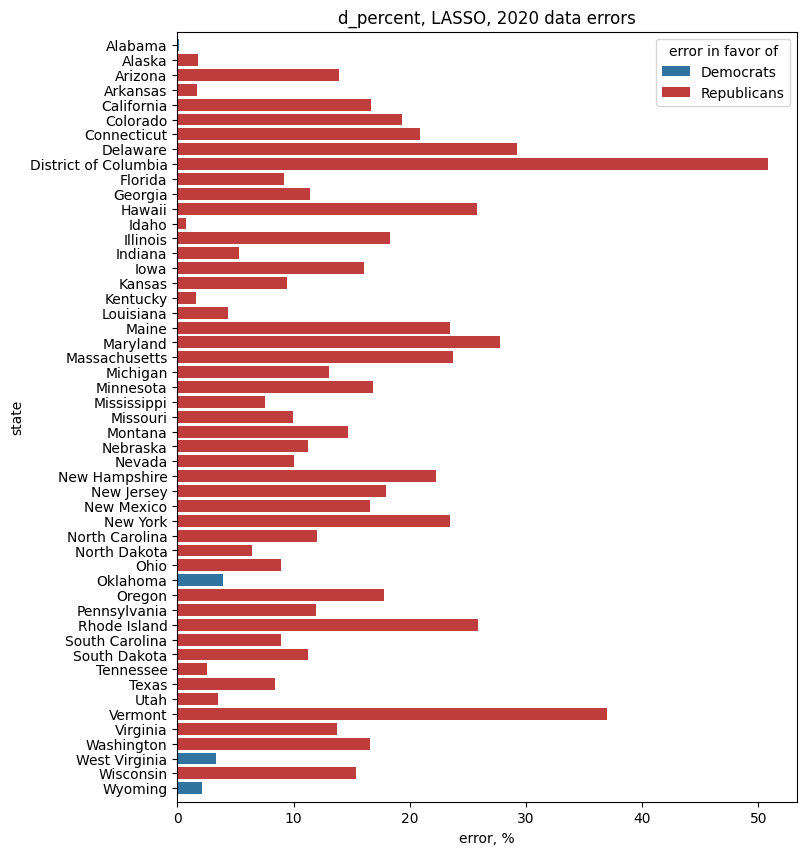

In [27]:
barplot_df=pd.DataFrame()
barplot_df['error, %']=las_search.best_estimator_.predict(X_2020)-y_2020
barplot_df['state']=data[data.year==2020].state
barplot_df['error in favor of']=np.where(barplot_df['error, %']>0,'Democrats','Republicans')
barplot_df['error, %']=np.abs(barplot_df['error, %'].to_numpy())
fig, ax=plt.subplots(figsize=(8,10))
ax=sns.barplot(data=barplot_df,
            x='error, %',
            y='state',
            hue='error in favor of',
            palette={'Republicans':'tab:red', 'Democrats':'tab:blue'},
            dodge=False)
ax.set(title=y_col+', LASSO, 2020 data errors')
ax.relim()
ax.autoscale_view()
ax.margins(y=0.01)

The initially chosen parameters were the best ones in the grid search. Looking at the model errors on the above plot, the model doesn't produce unrealistic results, but overall it's pretty inacurrate, underestimating the democratic share of votes in almost every state.

Building a Ridge model with alpha=1 using polynomial scaled features of degree 2.

In [28]:
Input=[ ('polynomial', PolynomialFeatures(include_bias=False,degree=2)),('ss',StandardScaler() ), ('model',Ridge(alpha=1))]
ridge_pipe = Pipeline(Input)

In [29]:
ridge_pipe.fit(X_train, y_train)
ridge_pred=ridge_pipe.predict(X_test)
print("Ridge R^2 on training  data ",ridge_pipe.score(X_train, y_train))
print("Ridge R^2 on testing data ",ridge_pipe.score(X_test,y_test))

C:\Users\Jade\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\extmath.py:193: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


Ridge R^2 on training  data  0.9999986674542296
Ridge R^2 on testing data  0.5171732976445823


In [30]:
print("Ridge Median error on testing data ",median_absolute_error(y_true=y_test, y_pred=ridge_pred))

Ridge Median error on testing data  3.578072574394241


In [31]:
print("Ridge R^2 on 2020 data ",ridge_pipe.score(X_2020,y_2020))
print("Ridge Median error on 2020 data ",median_absolute_error(y_true=y_2020, y_pred=ridge_pipe.predict(X_2020)))

Ridge R^2 on 2020 data  -3776.567092313158
Ridge Median error on 2020 data  68.13666433697588


In [32]:
ridge_pipe.fit(X, y)

C:\Users\Jade\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\extmath.py:193: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


Pipeline(steps=[('polynomial', PolynomialFeatures(include_bias=False)),
                ('ss', StandardScaler()), ('model', Ridge(alpha=1))])

In [33]:
print("Ridge fit on all data R^2 on 2020 data ",ridge_pipe.score(X_2020,y_2020))
print("Ridge fit on all data Median error on 2020 data ",median_absolute_error(y_true=y_2020, y_pred=ridge_pipe.predict(X_2020)))

Ridge fit on all data R^2 on 2020 data  -2580.344343868102
Ridge fit on all data Median error on 2020 data  50.97606707122901


Using the same train_test_split, Ridge does worse than Lasso but still better than plain linear regression.

Conducting cross validated grid search using a KFold object to pick the best value for the alpha and the polynomial degree.

In [34]:
param_grid = {
    "polynomial__degree": [1, 2],
    "model__alpha":[0.01,0.1,1,10, 20, 50, 100, 200, 400, 500]
}

In [35]:
ridge_search = GridSearchCV(ridge_pipe, param_grid, n_jobs=2, cv=kf)
ridge_search.fit(X, y)

GridSearchCV(cv=KFold(n_splits=10, random_state=72018, shuffle=True),
             estimator=Pipeline(steps=[('polynomial',
                                        PolynomialFeatures(include_bias=False)),
                                       ('ss', StandardScaler()),
                                       ('model', Ridge(alpha=1))]),
             n_jobs=2,
             param_grid={'model__alpha': [0.01, 0.1, 1, 10, 20, 50, 100, 200,
                                          400, 500],
                         'polynomial__degree': [1, 2]})

In [36]:
pd.DataFrame(ridge_search.cv_results_).sort_values(by='mean_test_score',ascending=False).head()

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
16       0.016525      0.005043         0.003029        0.004627   
14       0.015411      0.005310         0.003016        0.004607   
18       0.013926      0.004691         0.003009        0.004596   
12       0.011477      0.000805         0.005036        0.005036   
10       0.015304      0.004360         0.001644        0.003076   

   param_model__alpha param_polynomial__degree  \
16                400                        1   
14                200                        1   
18                500                        1   
12                100                        1   
10                 50                        1   

                                            params  split0_test_score  \
16  {'model__alpha': 400, 'polynomial__degree': 1}           0.564703   
14  {'model__alpha': 200, 'polynomial__degree': 1}           0.576561   
18  {'model__alpha': 500, 'polynomial__degree': 1}           0.557873   
12  {'model__alpha': 100, 'polynomial__degree': 1}           0.574340   
10   {'model__alpha': 50, 'polynomial__degree': 1}           0.560163   

    split1_test_score  split2_test_score  split3_test_score  \
16           0.666817           0.391418           0.547318   
14           0.707482           0.403802           0.580849   
18           0.648947           0.386330           0.534603   
12           0.729737           0.410131           0.610525   
10           0.739996           0.400430           0.638326   

    split4_test_score  split5_test_score  split6_test_score  \
16           0.579232           0.559237           0.573578   
14           0.601427           0.548046           0.598656   
18           0.568089           0.560614           0.563270   
12           0.610064           0.537543           0.618591   
10           0.612985           0.535626           0.635558   

    split7_test_score  split8_test_score  split9_test_score  mean_test_score  \
16           0.156851           0.427921           0.496335         0.496341   
14          -0.003865           0.452666           0.482472         0.494810   
18           0.199076           0.419534           0.497354         0.493569   
12          -0.227664           0.474008           0.461919         0.479919   
10          -0.597802           0.486900           0.446255         0.445844   

    std_test_score  rank_test_score  
16        0.135672                1  
14        0.185253                2  
18        0.121897                3  
12        0.251749                4  
10        0.360774                5

In [37]:
ridge_cv_pred=ridge_search.best_estimator_.predict(X_test)
print("Median error on testing data ",median_absolute_error(y_true=y_test, y_pred=ridge_cv_pred))

Median error on testing data  4.735498891199676


In [38]:
print("R^2 on 2020 data ",ridge_search.best_estimator_.score(X_2020,y_2020))
print("Median error on 2020 data ",median_absolute_error(y_true=y_2020, y_pred=ridge_search.best_estimator_.predict(X_2020)))

R^2 on 2020 data  -3.7490829790696774
Median error on 2020 data  18.580713274854737


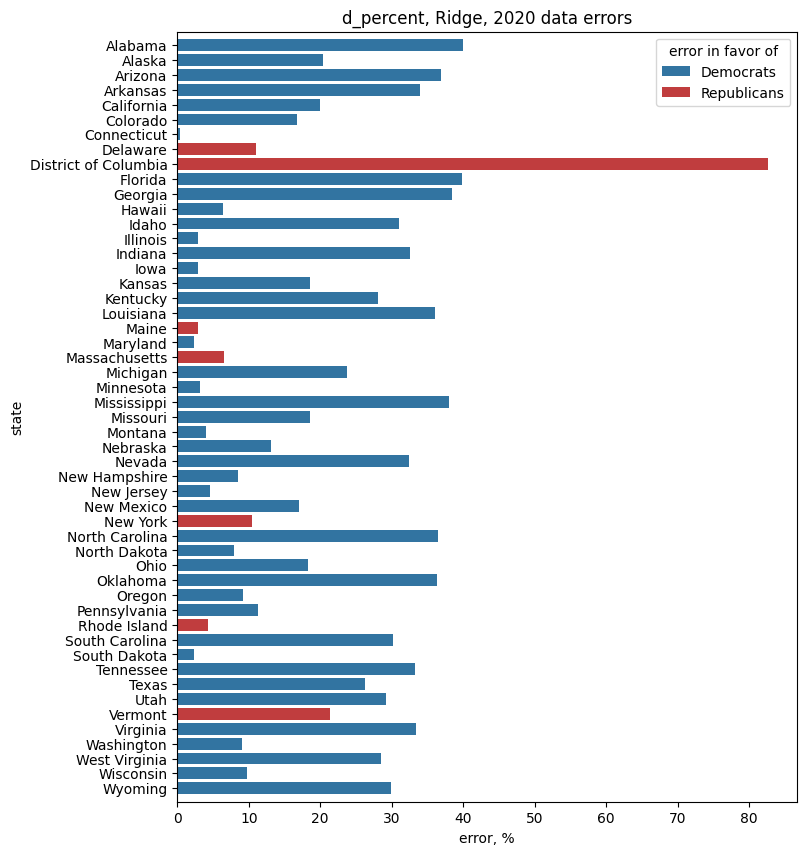

In [39]:
barplot_df=pd.DataFrame()
barplot_df['error, %']=ridge_search.best_estimator_.predict(X_2020)-y_2020
barplot_df['state']=data[data.year==2020].state
barplot_df['error in favor of']=np.where(barplot_df['error, %']>0,'Democrats','Republicans')
barplot_df['error, %']=np.abs(barplot_df['error, %'].to_numpy())
fig, ax=plt.subplots(figsize=(8,10))
ax=sns.barplot(data=barplot_df,
            x='error, %',
            y='state',
            hue='error in favor of',
            palette={'Republicans':'tab:red', 'Democrats':'tab:blue'},
            dodge=False)
ax.set(title=y_col+', Ridge, 2020 data errors')
ax.relim()
ax.autoscale_view()
ax.margins(y=0.01)

With best parameters found by the cross validated grid search, for this feature, Ridge does almost as well as Lasso: producing predictions that are possible, but not close to the truth, and mostly favoring one party.

The same code is run for the other 7 targets below.

# r_percent

In [40]:
y_col='r_percent'
X=df.drop(columns=columns_to_predict)
y=df[y_col]
X_2020=df_2020.drop(columns=columns_to_predict)
y_2020=df_2020[y_col]

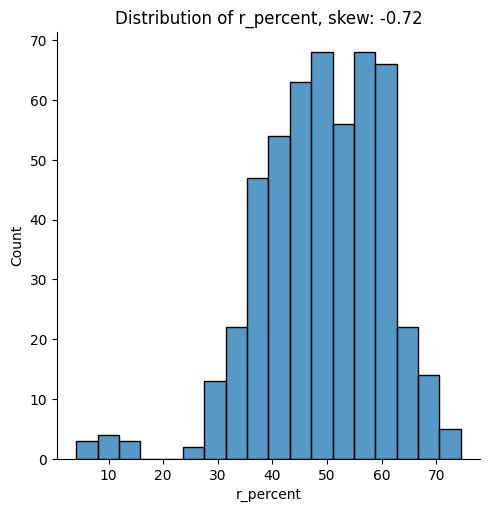

In [41]:
sns.displot(y).set(title='Distribution of '+y_col+', skew: '+str(y.skew())[:5])

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.1, random_state=42)
lm = LinearRegression()
lm.fit(X_train, y_train)
predicted = lm.predict(X_test)
print("Linear R^2 on training  data ",lm.score(X_train, y_train))
print("Linear R^2 on testing data ",lm.score(X_test,y_test))
print("Linear Median error on testing data ",median_absolute_error(y_true=y_test, y_pred=predicted))
print("Linear R^2 on 2020 data ",lm.score(X_2020,y_2020))
print("Linear Median error on 2020 data ",median_absolute_error(y_true=y_2020, y_pred=lm.predict(X_2020)))

Linear R^2 on training  data  0.919593452555676
Linear R^2 on testing data  0.6251520379399665
Linear Median error on testing data  4.496404724702458
Linear R^2 on 2020 data  -89728648.8191582
Linear Median error on 2020 data  32753.579124767286


In [43]:
Input=[ ('polynomial', PolynomialFeatures(include_bias=False,degree=2)),('ss',StandardScaler() ), ('model',Lasso(alpha=1, tol = 0.3))]
las_pipe = Pipeline(Input)
las_pipe.fit(X_train, y_train)
las_pred=las_pipe.predict(X_test)
print("LASSO R^2 on training  data ",las_pipe.score(X_train, y_train))
print("LASSO R^2 on testing data ",las_pipe.score(X_test,y_test))
print("LASSO Median error on testing data ",median_absolute_error(y_true=y_test, y_pred=las_pred))
print("LASSO R^2 on 2020 data ",las_pipe.score(X_2020,y_2020))
print("LASSO Median error on 2020 data ",median_absolute_error(y_true=y_2020, y_pred=las_pipe.predict(X_2020)))

LASSO R^2 on training  data  0.7034811356077111
LASSO R^2 on testing data  0.5386913539527602
LASSO Median error on testing data  5.831165340494472
LASSO R^2 on 2020 data  0.6059361124683889
LASSO Median error on 2020 data  5.255145384345777


In [44]:
las_pipe.fit(X, y)
print("Lasso fit on all data R^2 on 2020 data ",las_pipe.score(X_2020,y_2020))
print("Lasso fit on all data Median error on 2020 data ",median_absolute_error(y_true=y_2020, y_pred=las_pipe.predict(X_2020)))

Lasso fit on all data R^2 on 2020 data  0.47675216395285336
Lasso fit on all data Median error on 2020 data  7.236667705147497


In [45]:
kf = KFold(shuffle=True, random_state=72018, n_splits=10)
param_grid = {
    "polynomial__degree": [1, 2],
    "model__alpha":[0.01,0.1,1,10, 20]
}
las_search = GridSearchCV(las_pipe, param_grid, n_jobs=2, cv=kf)
las_search.fit(X, y)
pd.DataFrame(las_search.cv_results_).sort_values(by='mean_test_score',ascending=False).head()

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
5       0.790441      0.016981         0.029554        0.005758   
2       0.010075      0.000023         0.004021        0.004925   
4       0.012093      0.004033         0.007056        0.004619   
0       0.016207      0.005510         0.004608        0.002066   
3       0.690555      0.019220         0.029467        0.005528   

  param_model__alpha param_polynomial__degree  \
5                  1                        2   
2                0.1                        1   
4                  1                        1   
0               0.01                        1   
3                0.1                        2   

                                            params  split0_test_score  \
5     {'model__alpha': 1, 'polynomial__degree': 2}           0.629044   
2   {'model__alpha': 0.1, 'polynomial__degree': 1}           0.598385   
4     {'model__alpha': 1, 'polynomial__degree': 1}           0.567234   
0  {'model__alpha': 0.01, 'polynomial__degree': 1}           0.563086   
3   {'model__alpha': 0.1, 'polynomial__degree': 2}           0.517891   

   split1_test_score  split2_test_score  split3_test_score  split4_test_score  \
5           0.699397           0.543435           0.621005           0.700525   
2           0.759484           0.579588           0.538936           0.609383   
4           0.654621           0.517325           0.569540           0.563530   
0           0.752217           0.491760           0.555540           0.609616   
3          -0.427181           0.560102           0.666717           0.631769   

   split5_test_score  split6_test_score  split7_test_score  split8_test_score  \
5           0.631879           0.711864           0.567054           0.484563   
2           0.462222           0.708862           0.392830           0.478156   
4           0.549228           0.668961           0.519301           0.482644   
0           0.464387           0.689702          -0.039065           0.446054   
3           0.548463           0.734615           0.078979           0.656811   

   split9_test_score  mean_test_score  std_test_score  rank_test_score  
5           0.510936         0.609970        0.077038                1  
2           0.538224         0.566607        0.105326                2  
4           0.475020         0.556740        0.061380                3  
0           0.542633         0.507593        0.203656                4  
3           0.666809         0.463498        0.343874                5

In [46]:
las_cv_pred=las_search.best_estimator_.predict(X_test)
print("Lasso CV Median error on testing data ",median_absolute_error(y_true=y_test, y_pred=las_cv_pred))
print("Lasso CV R^2 on 2020 data ",las_search.best_estimator_.score(X_2020,y_2020))
print("Lasso CV Median error on 2020 data ",median_absolute_error(y_true=y_2020, y_pred=las_search.best_estimator_.predict(X_2020)))

Lasso CV Median error on testing data  5.860855789492277
Lasso CV R^2 on 2020 data  0.47675216395285336
Lasso CV Median error on 2020 data  7.236667705147497


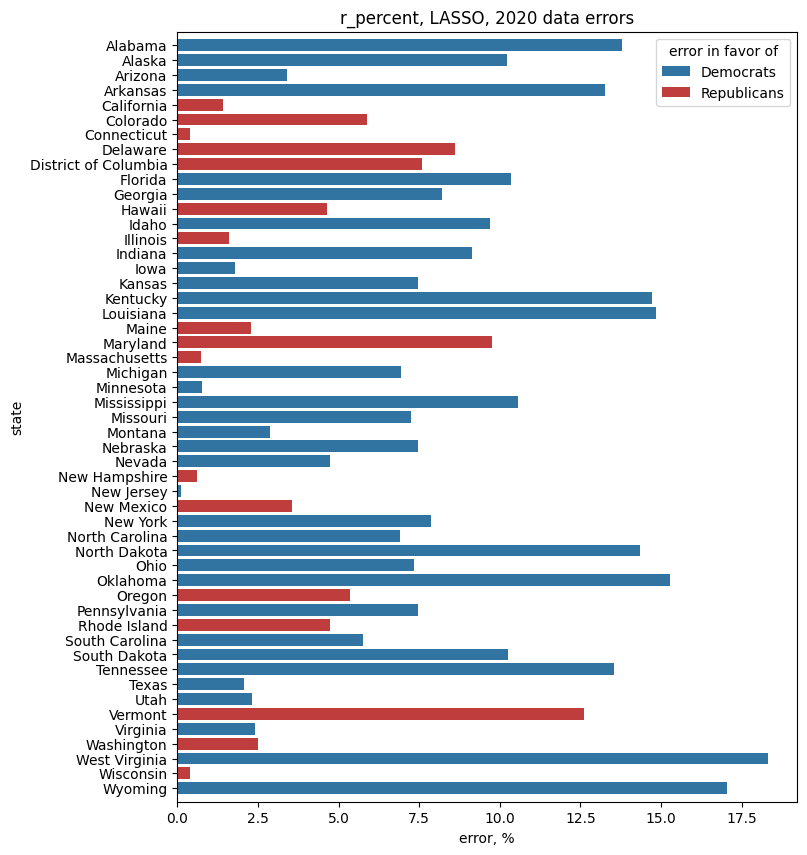

In [47]:
barplot_df=pd.DataFrame()
barplot_df['error, %']=las_search.best_estimator_.predict(X_2020)-y_2020
barplot_df['state']=data[data.year==2020].state
barplot_df['error in favor of']=np.where(barplot_df['error, %']<0,'Democrats','Republicans')
barplot_df['error, %']=np.abs(barplot_df['error, %'].to_numpy())
fig, ax=plt.subplots(figsize=(8,10))
ax=sns.barplot(data=barplot_df,
            x='error, %',
            y='state',
            hue='error in favor of',
            palette={'Republicans':'tab:red', 'Democrats':'tab:blue'},
            dodge=False)
ax.set(title=y_col+', LASSO, 2020 data errors')
ax.relim()
ax.autoscale_view()
ax.margins(y=0.01)

In [48]:
Input=[ ('polynomial', PolynomialFeatures(include_bias=False,degree=2)),('ss',StandardScaler() ), ('model',Ridge(alpha=1))]
ridge_pipe = Pipeline(Input)
ridge_pipe.fit(X_train, y_train)
ridge_pred=ridge_pipe.predict(X_test)
print("Ridge R^2 on training  data ",ridge_pipe.score(X_train, y_train))
print("Ridge R^2 on testing data ",ridge_pipe.score(X_test,y_test))
print("Ridge Median error on testing data ",median_absolute_error(y_true=y_test, y_pred=ridge_pred))
print("Ridge R^2 on 2020 data ",ridge_pipe.score(X_2020,y_2020))
print("Ridge Median error on 2020 data ",median_absolute_error(y_true=y_2020, y_pred=ridge_pipe.predict(X_2020)))

C:\Users\Jade\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\extmath.py:193: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


Ridge R^2 on training  data  0.9999988093147332
Ridge R^2 on testing data  0.5736599134142257
Ridge Median error on testing data  3.8153937397806317
Ridge R^2 on 2020 data  -2413.598727044998
Ridge Median error on 2020 data  84.96263030687442


In [49]:
ridge_pipe.fit(X, y)
print("Ridge fit on all data R^2 on 2020 data ",ridge_pipe.score(X_2020,y_2020))
print("Ridge fit on all data Median error on 2020 data ",median_absolute_error(y_true=y_2020, y_pred=ridge_pipe.predict(X_2020)))

Ridge fit on all data R^2 on 2020 data  -1364.212423421209
Ridge fit on all data Median error on 2020 data  60.39138756464475


C:\Users\Jade\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\extmath.py:193: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


In [50]:
kf = KFold(shuffle=True, random_state=72018, n_splits=10)
param_grid = {
    "polynomial__degree": [1, 2],
    "model__alpha":[0.01,0.1,1,10, 20, 50, 100, 200, 400, 500]
}
ridge_search = GridSearchCV(ridge_pipe, param_grid, n_jobs=2, cv=kf)
ridge_search.fit(X, y)
pd.DataFrame(ridge_search.cv_results_).sort_values(by='mean_test_score',ascending=False).head()

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
14       0.015366      0.003917         0.000991        0.001245   
12       0.013021      0.002738         0.003016        0.004607   
16       0.012995      0.002874         0.002012        0.004024   
18       0.017272      0.004624         0.000000        0.000000   
10       0.012767      0.003719         0.003569        0.005088   

   param_model__alpha param_polynomial__degree  \
14                200                        1   
12                100                        1   
16                400                        1   
18                500                        1   
10                 50                        1   

                                            params  split0_test_score  \
14  {'model__alpha': 200, 'polynomial__degree': 1}           0.639041   
12  {'model__alpha': 100, 'polynomial__degree': 1}           0.632059   
16  {'model__alpha': 400, 'polynomial__degree': 1}           0.633124   
18  {'model__alpha': 500, 'polynomial__degree': 1}           0.628013   
10   {'model__alpha': 50, 'polynomial__degree': 1}           0.615071   

    split1_test_score  split2_test_score  split3_test_score  \
14           0.775825           0.606450           0.572511   
12           0.787947           0.600106           0.597101   
16           0.747199           0.590956           0.546864   
18           0.733409           0.581083           0.537826   
10           0.789419           0.570934           0.619914   

    split4_test_score  split5_test_score  split6_test_score  \
14           0.643775           0.658915           0.734907   
12           0.644952           0.658645           0.751263   
16           0.633366           0.655849           0.708953   
18           0.626847           0.651388           0.697446   
10           0.643657           0.664248           0.761900   

    split7_test_score  split8_test_score  split9_test_score  mean_test_score  \
14           0.423360           0.525590           0.588036         0.616841   
12           0.340808           0.546007           0.577840         0.613673   
16           0.468602           0.507801           0.590550         0.608326   
18           0.477998           0.501331           0.587514         0.602285   
10           0.167778           0.570252           0.571496         0.597467   

    std_test_score  rank_test_score  
14        0.095325                1  
12        0.115507                2  
16        0.081814                3  
18        0.077709                4  
10        0.160637                5

In [51]:
ridge_cv_pred=ridge_search.best_estimator_.predict(X_test)
print("Median error on testing data ",median_absolute_error(y_true=y_test, y_pred=ridge_cv_pred))
print("R^2 on 2020 data ",ridge_search.best_estimator_.score(X_2020,y_2020))
print("Median error on 2020 data ",median_absolute_error(y_true=y_2020, y_pred=ridge_search.best_estimator_.predict(X_2020)))

Median error on testing data  4.651514943165296
R^2 on 2020 data  -15.919463358535985
Median error on 2020 data  36.549452723151134


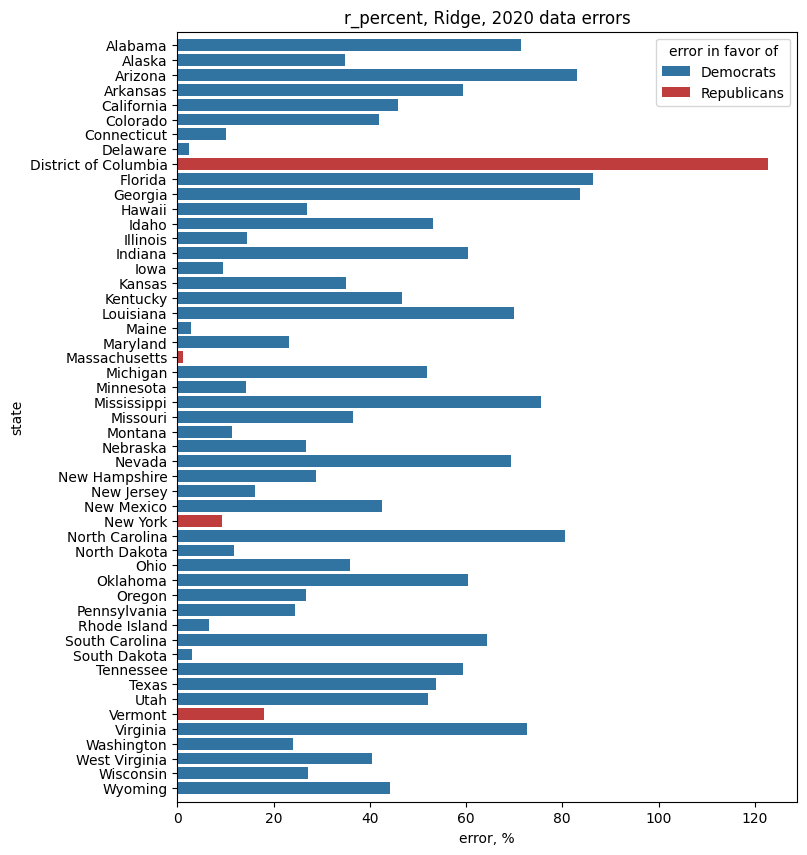

In [52]:
barplot_df=pd.DataFrame()
barplot_df['error, %']=ridge_search.best_estimator_.predict(X_2020)-y_2020
barplot_df['state']=data[data.year==2020].state
barplot_df['error in favor of']=np.where(barplot_df['error, %']<0,'Democrats','Republicans')
barplot_df['error, %']=np.abs(barplot_df['error, %'].to_numpy())
fig, ax=plt.subplots(figsize=(8,10))
ax=sns.barplot(data=barplot_df,
            x='error, %',
            y='state',
            hue='error in favor of',
            palette={'Republicans':'tab:red', 'Democrats':'tab:blue'},
            dodge=False)
ax.set(title=y_col+', Ridge, 2020 data errors')
ax.relim()
ax.autoscale_view()
ax.margins(y=0.01)

# dr_percent

dr_percent > 0 : difference between D and R votes is positive, meaning that the Democratic candidate won the election

In [53]:
y_col='dr_percent'
X=df.drop(columns=columns_to_predict)
y=df[y_col]
X_2020=df_2020.drop(columns=columns_to_predict)
y_2020=df_2020[y_col]

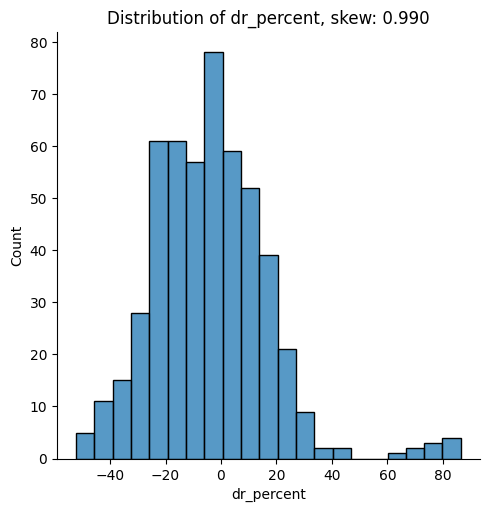

In [54]:
sns.displot(y).set(title='Distribution of '+y_col+', skew: '+str(y.skew())[:5])

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.1, random_state=42)
lm = LinearRegression()
lm.fit(X_train, y_train)
predicted = lm.predict(X_test)
print("Linear R^2 on training  data ",lm.score(X_train, y_train))
print("Linear R^2 on testing data ",lm.score(X_test,y_test))
print("Linear Median error on testing data ",median_absolute_error(y_true=y_test, y_pred=predicted))
print("Linear R^2 on 2020 data ",lm.score(X_2020,y_2020))
print("Linear Median error on 2020 data ",median_absolute_error(y_true=y_2020, y_pred=lm.predict(X_2020)))

Linear R^2 on training  data  0.9030738771342994
Linear R^2 on testing data  0.48234861269802676
Linear Median error on testing data  8.358784125897092
Linear R^2 on 2020 data  -9398357.675057104
Linear Median error on 2020 data  39457.664352852786


In [56]:
Input=[ ('polynomial', PolynomialFeatures(include_bias=False,degree=2)),('ss',StandardScaler() ), ('model',Lasso(alpha=1, tol = 0.3))]
las_pipe = Pipeline(Input)
las_pipe.fit(X_train, y_train)
las_pred=las_pipe.predict(X_test)
print("LASSO R^2 on training  data ",las_pipe.score(X_train, y_train))
print("LASSO R^2 on testing data ",las_pipe.score(X_test,y_test))
print("LASSO Median error on testing data ",median_absolute_error(y_true=y_test, y_pred=las_pred))
print("LASSO R^2 on 2020 data ",las_pipe.score(X_2020,y_2020))
print("LASSO Median error on 2020 data ",median_absolute_error(y_true=y_2020, y_pred=las_pipe.predict(X_2020)))

LASSO R^2 on training  data  0.7684657940158197
LASSO R^2 on testing data  0.6308661393209021
LASSO Median error on testing data  8.894944810015097
LASSO R^2 on 2020 data  -5.631491984140876
LASSO Median error on 2020 data  55.96233257381925


In [57]:
las_pipe.fit(X, y)
print("Lasso fit on all data R^2 on 2020 data ",las_pipe.score(X_2020,y_2020))
print("Lasso fit on all data Median error on 2020 data ",median_absolute_error(y_true=y_2020, y_pred=las_pipe.predict(X_2020)))

Lasso fit on all data R^2 on 2020 data  -15.955463903434516
Lasso fit on all data Median error on 2020 data  85.5420021563712


In [58]:
kf = KFold(shuffle=True, random_state=72018, n_splits=10)
param_grid = {
    "polynomial__degree": [1, 2],
    "model__alpha":[0.01,0.1,0.5,1,2,10, 20]
}
las_search = GridSearchCV(las_pipe, param_grid, n_jobs=2, cv=kf)
las_search.fit(X, y)
pd.DataFrame(las_search.cv_results_).sort_values(by='mean_test_score',ascending=False).head()

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
7       0.763206      0.037256         0.029720        0.005494   
5       0.782694      0.040985         0.032558        0.002854   
9       0.729226      0.028746         0.030263        0.000058   
6       0.013112      0.000499         0.003407        0.000432   
4       0.012480      0.003987         0.001556        0.003053   

  param_model__alpha param_polynomial__degree  \
7                  1                        2   
5                0.5                        2   
9                  2                        2   
6                  1                        1   
4                0.5                        1   

                                           params  split0_test_score  \
7    {'model__alpha': 1, 'polynomial__degree': 2}           0.571225   
5  {'model__alpha': 0.5, 'polynomial__degree': 2}           0.547541   
9    {'model__alpha': 2, 'polynomial__degree': 2}           0.573217   
6    {'model__alpha': 1, 'polynomial__degree': 1}           0.562298   
4  {'model__alpha': 0.5, 'polynomial__degree': 1}           0.554198   

   split1_test_score  split2_test_score  split3_test_score  split4_test_score  \
7           0.731128           0.543710           0.620232           0.622699   
5           0.428159           0.611685           0.672040           0.638116   
9           0.693954           0.505659           0.613384           0.576226   
6           0.690409           0.499674           0.554462           0.514648   
4           0.692919           0.531361           0.532336           0.567724   

   split5_test_score  split6_test_score  split7_test_score  split8_test_score  \
7           0.631366           0.699831           0.404478           0.586481   
5           0.606360           0.742766           0.375640           0.661149   
9           0.576544           0.645171           0.354485           0.508815   
6           0.554817           0.670832           0.347196           0.410521   
4           0.470308           0.656359           0.377692           0.370212   

   split9_test_score  mean_test_score  std_test_score  rank_test_score  
7           0.570819         0.598197        0.085027                1  
5           0.613965         0.589742        0.106161                2  
9           0.482245         0.552970        0.090620                3  
6           0.453759         0.525862        0.101149                4  
4           0.500476         0.525359        0.098729                5

In [59]:
las_cv_pred=las_search.best_estimator_.predict(X_test)
print("Lasso CV Median error on testing data ",median_absolute_error(y_true=y_test, y_pred=las_cv_pred))
print("Lasso CV R^2 on 2020 data ",las_search.best_estimator_.score(X_2020,y_2020))
print("Lasso CV Median error on 2020 data ",median_absolute_error(y_true=y_2020, y_pred=las_search.best_estimator_.predict(X_2020)))

Lasso CV Median error on testing data  8.284263978325122
Lasso CV R^2 on 2020 data  -15.955463903434516
Lasso CV Median error on 2020 data  85.5420021563712


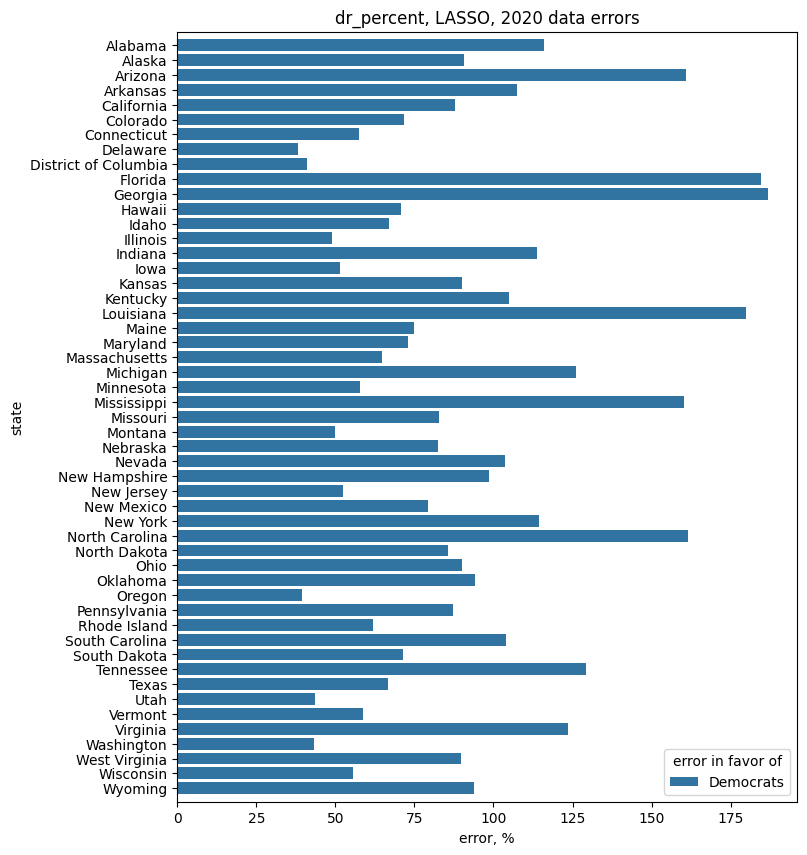

In [60]:
barplot_df=pd.DataFrame()
barplot_df['error, %']=las_search.best_estimator_.predict(X_2020)-y_2020
barplot_df['state']=data[data.year==2020].state
barplot_df['error in favor of']=np.where(barplot_df['error, %']>0,'Democrats','Republicans')
barplot_df['error, %']=np.abs(barplot_df['error, %'].to_numpy())
fig, ax=plt.subplots(figsize=(8,10))
ax=sns.barplot(data=barplot_df,
            x='error, %',
            y='state',
            hue='error in favor of',
            palette={'Republicans':'tab:red', 'Democrats':'tab:blue'},
            dodge=False)
ax.set(title=y_col+', LASSO, 2020 data errors')
ax.relim()
ax.autoscale_view()
ax.margins(y=0.01)

In [61]:
Input=[ ('polynomial', PolynomialFeatures(include_bias=False,degree=2)),('ss',StandardScaler() ), ('model',Ridge(alpha=1))]
ridge_pipe = Pipeline(Input)
ridge_pipe.fit(X_train, y_train)
ridge_pred=ridge_pipe.predict(X_test)
print("Ridge R^2 on training  data ",ridge_pipe.score(X_train, y_train))
print("Ridge R^2 on testing data ",ridge_pipe.score(X_test,y_test))
print("Ridge Median error on testing data ",median_absolute_error(y_true=y_test, y_pred=ridge_pred))
print("Ridge R^2 on 2020 data ",ridge_pipe.score(X_2020,y_2020))
print("Ridge Median error on 2020 data ",median_absolute_error(y_true=y_2020, y_pred=ridge_pipe.predict(X_2020)))

C:\Users\Jade\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\extmath.py:193: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


Ridge R^2 on training  data  0.999998684256299
Ridge R^2 on testing data  0.5100600584973936
Ridge Median error on testing data  7.862539746237719
Ridge R^2 on 2020 data  -3052.474258428123
Ridge Median error on 2020 data  151.22388803477173


In [62]:
ridge_pipe.fit(X, y)
print("Ridge fit on all data R^2 on 2020 data ",ridge_pipe.score(X_2020,y_2020))
print("Ridge fit on all data Median error on 2020 data ",median_absolute_error(y_true=y_2020, y_pred=ridge_pipe.predict(X_2020)))

Ridge fit on all data R^2 on 2020 data  -1919.673625019434
Ridge fit on all data Median error on 2020 data  116.25538483273951


C:\Users\Jade\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\extmath.py:193: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


In [63]:
kf = KFold(shuffle=True, random_state=72018, n_splits=10)
param_grid = {
    "polynomial__degree": [1, 2],
    "model__alpha":[0.01,0.1,1,10, 20, 50, 100, 200, 400, 500]
}
ridge_search = GridSearchCV(ridge_pipe, param_grid, n_jobs=2, cv=kf)
ridge_search.fit(X, y)
pd.DataFrame(ridge_search.cv_results_).sort_values(by='mean_test_score',ascending=False).head()

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
14       0.017474      0.004737         0.005029        0.005029   
16       0.016315      0.005091         0.004099        0.005009   
18       0.015049      0.004671         0.004609        0.004493   
12       0.014267      0.005171         0.003325        0.004690   
10       0.011718      0.002898         0.000000        0.000000   

   param_model__alpha param_polynomial__degree  \
14                200                        1   
16                400                        1   
18                500                        1   
12                100                        1   
10                 50                        1   

                                            params  split0_test_score  \
14  {'model__alpha': 200, 'polynomial__degree': 1}           0.590826   
16  {'model__alpha': 400, 'polynomial__degree': 1}           0.582366   
18  {'model__alpha': 500, 'polynomial__degree': 1}           0.576724   
12  {'model__alpha': 100, 'polynomial__degree': 1}           0.586205   
10   {'model__alpha': 50, 'polynomial__degree': 1}           0.570701   

    split1_test_score  split2_test_score  split3_test_score  \
14           0.727805           0.505267           0.559561   
16           0.693356           0.498321           0.528724   
18           0.677537           0.492405           0.517696   
12           0.744427           0.497496           0.588778   
10           0.749342           0.471562           0.616468   

    split4_test_score  split5_test_score  split6_test_score  \
14           0.608609           0.575950           0.667476   
16           0.592185           0.584282           0.641186   
18           0.583283           0.584292           0.629934   
12           0.613539           0.567996           0.685947   
10           0.614559           0.569457           0.699934   

    split7_test_score  split8_test_score  split9_test_score  mean_test_score  \
14           0.183228           0.435781           0.523714         0.537822   
16           0.285519           0.415009           0.532822         0.535377   
18           0.311265           0.408299           0.532033         0.531347   
12           0.028454           0.458354           0.507332         0.527853   
10          -0.252819           0.479726           0.495771         0.501470   

    std_test_score  rank_test_score  
14        0.141442                1  
16        0.110599                2  
18        0.101946                3  
12        0.185348                4  
10        0.265821                5

In [64]:
ridge_cv_pred=ridge_search.best_estimator_.predict(X_test)
print("Median error on testing data ",median_absolute_error(y_true=y_test, y_pred=ridge_cv_pred))
print("R^2 on 2020 data ",ridge_search.best_estimator_.score(X_2020,y_2020))
print("Median error on 2020 data ",median_absolute_error(y_true=y_2020, y_pred=ridge_search.best_estimator_.predict(X_2020)))

Median error on testing data  9.405200518369234
R^2 on 2020 data  -12.232046214578546
Median error on 2020 data  69.08119960412726


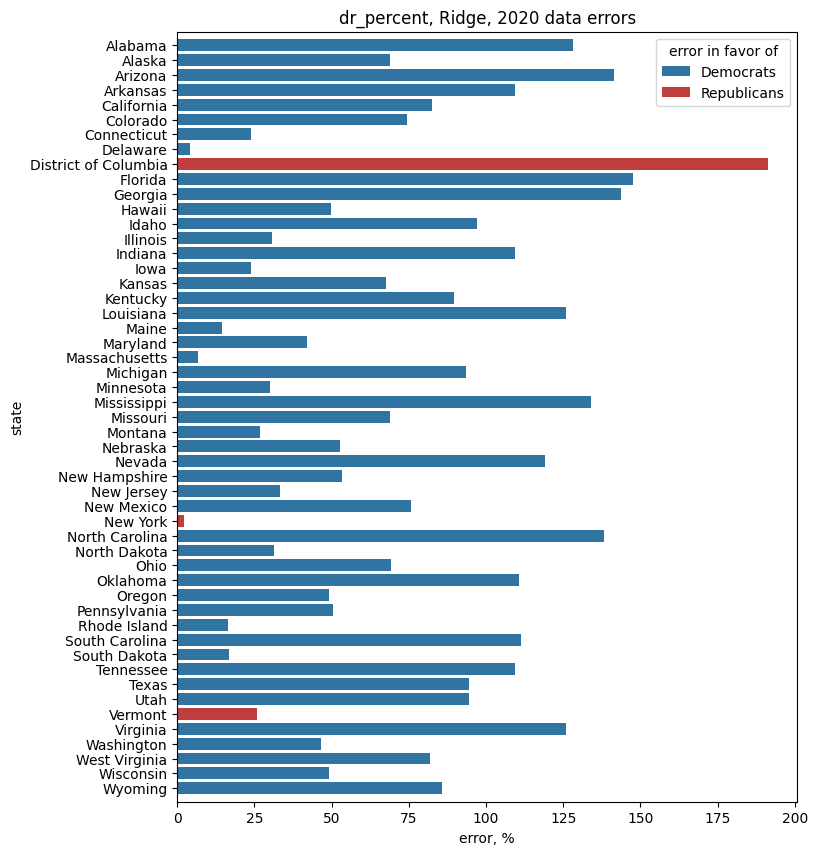

In [65]:
barplot_df=pd.DataFrame()
barplot_df['error, %']=ridge_search.best_estimator_.predict(X_2020)-y_2020
barplot_df['state']=data[data.year==2020].state
barplot_df['error in favor of']=np.where(barplot_df['error, %']>0,'Democrats','Republicans')
barplot_df['error, %']=np.abs(barplot_df['error, %'].to_numpy())
fig, ax=plt.subplots(figsize=(8,10))
ax=sns.barplot(data=barplot_df,
            x='error, %',
            y='state',
            hue='error in favor of',
            palette={'Republicans':'tab:red', 'Democrats':'tab:blue'},
            dodge=False)
ax.set(title=y_col+', Ridge, 2020 data errors')
ax.relim()
ax.autoscale_view()
ax.margins(y=0.01)

# dr_swing

In [66]:
y_col='dr_swing'
X=df.drop(columns=columns_to_predict)
y=df[y_col]
X_2020=df_2020.drop(columns=columns_to_predict)
y_2020=df_2020[y_col]

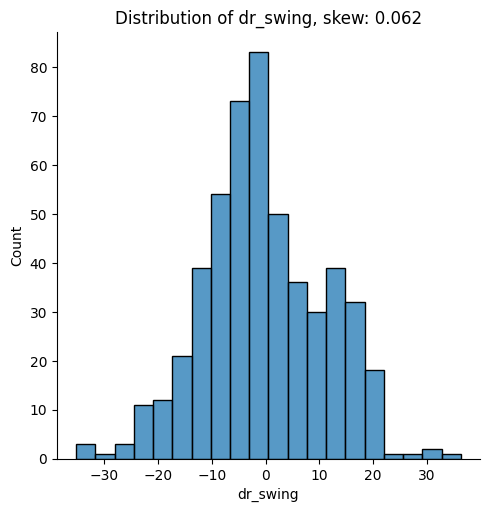

In [67]:
sns.displot(y).set(title='Distribution of '+y_col+', skew: '+str(y.skew())[:5])

In [68]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.1, random_state=42)
lm = LinearRegression()
lm.fit(X_train, y_train)
predicted = lm.predict(X_test)
print("Linear R^2 on training  data ",lm.score(X_train, y_train))
print("Linear R^2 on testing data ",lm.score(X_test,y_test))
print("Linear Median error on testing data ",median_absolute_error(y_true=y_test, y_pred=predicted))
print("Linear R^2 on 2020 data ",lm.score(X_2020,y_2020))
print("Linear Median error on 2020 data ",median_absolute_error(y_true=y_2020, y_pred=lm.predict(X_2020)))

Linear R^2 on training  data  0.8534508764922205
Linear R^2 on testing data  0.5926002666198061
Linear Median error on testing data  6.081998343634973
Linear R^2 on 2020 data  -21904372539.28202
Linear Median error on 2020 data  68490.87290109957


In [69]:
Input=[ ('polynomial', PolynomialFeatures(include_bias=False,degree=2)),('ss',StandardScaler() ), ('model',Lasso(alpha=1, tol = 0.3))]
las_pipe = Pipeline(Input)
las_pipe.fit(X_train, y_train)
las_pred=las_pipe.predict(X_test)
print("LASSO R^2 on training  data ",las_pipe.score(X_train, y_train))
print("LASSO R^2 on testing data ",las_pipe.score(X_test,y_test))
print("LASSO Median error on testing data ",median_absolute_error(y_true=y_test, y_pred=las_pred))
print("LASSO R^2 on 2020 data ",las_pipe.score(X_2020,y_2020))
print("LASSO Median error on 2020 data ",median_absolute_error(y_true=y_2020, y_pred=las_pipe.predict(X_2020)))

LASSO R^2 on training  data  0.6844936955645259
LASSO R^2 on testing data  0.586855909647015
LASSO Median error on testing data  5.033400216652699
LASSO R^2 on 2020 data  -50.57807705987121
LASSO Median error on 2020 data  16.04986266019966


In [70]:
las_pipe.fit(X, y)
print("Lasso fit on all data R^2 on 2020 data ",las_pipe.score(X_2020,y_2020))
print("Lasso fit on all data Median error on 2020 data ",median_absolute_error(y_true=y_2020, y_pred=las_pipe.predict(X_2020)))

Lasso fit on all data R^2 on 2020 data  -42.03052438923531
Lasso fit on all data Median error on 2020 data  14.653170181186383


In [71]:
kf = KFold(shuffle=True, random_state=72018, n_splits=10)
param_grid = {
    "polynomial__degree": [1, 2],
    "model__alpha":[0.01,0.1,1,10, 20]
}
las_search = GridSearchCV(las_pipe, param_grid, n_jobs=2, cv=kf)
las_search.fit(X, y)
pd.DataFrame(las_search.cv_results_).sort_values(by='mean_test_score',ascending=False).head()

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
5       0.758279      0.026305         0.029742        0.003271   
4       0.015124      0.005017         0.001007        0.003012   
2       0.012089      0.004054         0.003027        0.004623   
0       0.015796      0.003250         0.004204        0.000650   
3       0.712218      0.025298         0.029377        0.003064   

  param_model__alpha param_polynomial__degree  \
5                  1                        2   
4                  1                        1   
2                0.1                        1   
0               0.01                        1   
3                0.1                        2   

                                            params  split0_test_score  \
5     {'model__alpha': 1, 'polynomial__degree': 2}           0.681802   
4     {'model__alpha': 1, 'polynomial__degree': 1}           0.644076   
2   {'model__alpha': 0.1, 'polynomial__degree': 1}           0.690843   
0  {'model__alpha': 0.01, 'polynomial__degree': 1}           0.660790   
3   {'model__alpha': 0.1, 'polynomial__degree': 2}           0.504082   

   split1_test_score  split2_test_score  split3_test_score  split4_test_score  \
5           0.680598           0.658078           0.437188           0.631472   
4           0.616727           0.641183           0.394595           0.579998   
2           0.693372           0.628659           0.316216           0.711086   
0           0.646673           0.610122           0.301234           0.713335   
3          -0.209248           0.539552           0.271825           0.702311   

   split5_test_score  split6_test_score  split7_test_score  split8_test_score  \
5           0.633288           0.492659           0.541599           0.694224   
4           0.598956           0.563976           0.539949           0.681674   
2           0.579607           0.545290           0.297174           0.650924   
0           0.524940           0.507971           0.118054           0.630618   
3           0.438292           0.429452           0.146715           0.643016   

   split9_test_score  mean_test_score  std_test_score  rank_test_score  
5           0.666192         0.611710        0.084846                1  
4           0.634361         0.589549        0.076272                2  
2           0.638644         0.575181        0.142725                3  
0           0.527513         0.524125        0.174092                4  
3           0.624100         0.409010        0.261585                5

In [72]:
las_cv_pred=las_search.best_estimator_.predict(X_test)
print("Lasso CV Median error on testing data ",median_absolute_error(y_true=y_test, y_pred=las_cv_pred))
print("Lasso CV R^2 on 2020 data ",las_search.best_estimator_.score(X_2020,y_2020))
print("Lasso CV Median error on 2020 data ",median_absolute_error(y_true=y_2020, y_pred=las_search.best_estimator_.predict(X_2020)))

Lasso CV Median error on testing data  4.472494452989041
Lasso CV R^2 on 2020 data  -42.03052438923531
Lasso CV Median error on 2020 data  14.653170181186383


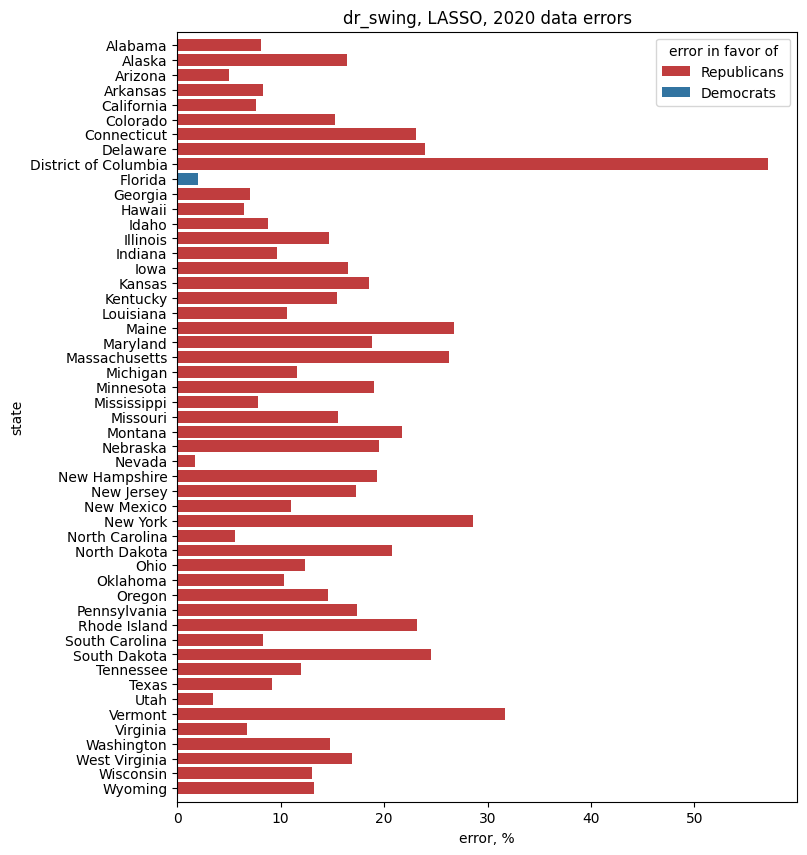

In [73]:
barplot_df=pd.DataFrame()
barplot_df['error, %']=las_search.best_estimator_.predict(X_2020)-y_2020
barplot_df['state']=data[data.year==2020].state
barplot_df['error in favor of']=np.where(barplot_df['error, %']>0,'Democrats','Republicans')
barplot_df['error, %']=np.abs(barplot_df['error, %'].to_numpy())
fig, ax=plt.subplots(figsize=(8,10))
ax=sns.barplot(data=barplot_df,
            x='error, %',
            y='state',
            hue='error in favor of',
            palette={'Republicans':'tab:red', 'Democrats':'tab:blue'},
            dodge=False)
ax.set(title=y_col+', LASSO, 2020 data errors')
ax.relim()
ax.autoscale_view()
ax.margins(y=0.01)

In [74]:
Input=[ ('polynomial', PolynomialFeatures(include_bias=False,degree=2)),('ss',StandardScaler() ), ('model',Ridge(alpha=1))]
ridge_pipe = Pipeline(Input)
ridge_pipe.fit(X_train, y_train)
ridge_pred=ridge_pipe.predict(X_test)
print("Ridge R^2 on training  data ",ridge_pipe.score(X_train, y_train))
print("Ridge R^2 on testing data ",ridge_pipe.score(X_test,y_test))
print("Ridge Median error on testing data ",median_absolute_error(y_true=y_test, y_pred=ridge_pred))
print("Ridge R^2 on 2020 data ",ridge_pipe.score(X_2020,y_2020))
print("Ridge Median error on 2020 data ",median_absolute_error(y_true=y_2020, y_pred=ridge_pipe.predict(X_2020)))

C:\Users\Jade\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\extmath.py:193: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


Ridge R^2 on training  data  0.9999983146980957
Ridge R^2 on testing data  0.2664581309134242
Ridge Median error on testing data  5.813234091964871
Ridge R^2 on 2020 data  -14224.20178556329
Ridge Median error on 2020 data  131.51239036092954


In [75]:
ridge_pipe.fit(X, y)
print("Ridge fit on all data R^2 on 2020 data ",ridge_pipe.score(X_2020,y_2020))
print("Ridge fit on all data Median error on 2020 data ",median_absolute_error(y_true=y_2020, y_pred=ridge_pipe.predict(X_2020)))

Ridge fit on all data R^2 on 2020 data  -13711.23302730137
Ridge fit on all data Median error on 2020 data  167.69722572626168


C:\Users\Jade\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\extmath.py:193: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


In [76]:
kf = KFold(shuffle=True, random_state=72018, n_splits=10)
param_grid = {
    "polynomial__degree": [1, 2],
    "model__alpha":[0.01,0.1,1,10, 20, 50, 100, 200, 400, 500]
}
ridge_search = GridSearchCV(ridge_pipe, param_grid, n_jobs=2, cv=kf)
ridge_search.fit(X, y)
pd.DataFrame(ridge_search.cv_results_).sort_values(by='mean_test_score',ascending=False).head()

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
16       0.016276      0.004790         0.004041        0.004949   
14       0.015269      0.005916         0.001231        0.003018   
18       0.015052      0.004741         0.000423        0.000855   
12       0.012624      0.003795         0.003704        0.005001   
10       0.015324      0.005668         0.000000        0.000000   

   param_model__alpha param_polynomial__degree  \
16                400                        1   
14                200                        1   
18                500                        1   
12                100                        1   
10                 50                        1   

                                            params  split0_test_score  \
16  {'model__alpha': 400, 'polynomial__degree': 1}           0.708501   
14  {'model__alpha': 200, 'polynomial__degree': 1}           0.697206   
18  {'model__alpha': 500, 'polynomial__degree': 1}           0.709679   
12  {'model__alpha': 100, 'polynomial__degree': 1}           0.680304   
10   {'model__alpha': 50, 'polynomial__degree': 1}           0.662250   

    split1_test_score  split2_test_score  split3_test_score  \
16           0.725091           0.703413           0.387703   
14           0.744865           0.717660           0.370473   
18           0.716090           0.694090           0.391729   
12           0.755938           0.708616           0.350544   
10           0.761273           0.672150           0.330991   

    split4_test_score  split5_test_score  split6_test_score  \
16           0.700123           0.655712           0.606675   
14           0.712732           0.640312           0.612042   
18           0.693376           0.657095           0.602439   
12           0.715178           0.616030           0.607761   
10           0.708578           0.588864           0.596425   

    split7_test_score  split8_test_score  split9_test_score  mean_test_score  \
16           0.548681           0.662654           0.718163         0.641672   
14           0.523859           0.672577           0.721595         0.641332   
18           0.555312           0.657331           0.715902         0.639305   
12           0.520023           0.676813           0.724512         0.635572   
10           0.558577           0.678616           0.729706         0.628743   

    std_test_score  rank_test_score  
16        0.099757                1  
14        0.109639                2  
18        0.096431                3  
12        0.115551                4  
10        0.116550                5

In [77]:
ridge_cv_pred=ridge_search.best_estimator_.predict(X_test)
print("Median error on testing data ",median_absolute_error(y_true=y_test, y_pred=ridge_cv_pred))
print("R^2 on 2020 data ",ridge_search.best_estimator_.score(X_2020,y_2020))
print("Median error on 2020 data ",median_absolute_error(y_true=y_2020, y_pred=ridge_search.best_estimator_.predict(X_2020)))

Median error on testing data  4.664033062086483
R^2 on 2020 data  -571.0198909726176
Median error on 2020 data  46.77791402350788


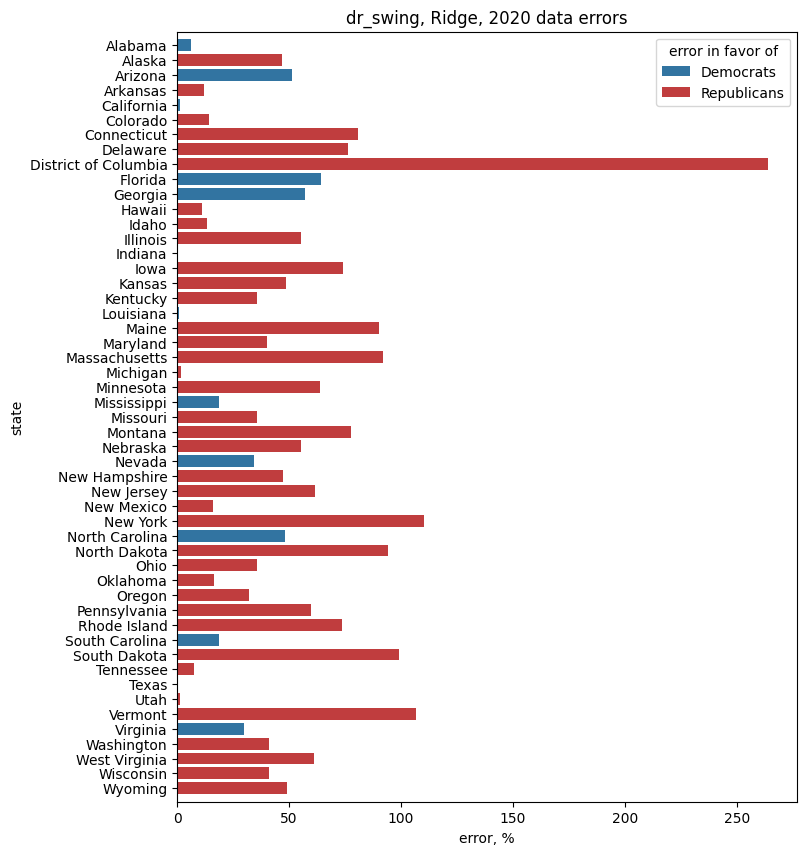

In [78]:
barplot_df=pd.DataFrame()
barplot_df['error, %']=ridge_search.best_estimator_.predict(X_2020)-y_2020
barplot_df['state']=data[data.year==2020].state
barplot_df['error in favor of']=np.where(barplot_df['error, %']>0,'Democrats','Republicans')
barplot_df['error, %']=np.abs(barplot_df['error, %'].to_numpy())
fig, ax=plt.subplots(figsize=(8,10))
ax=sns.barplot(data=barplot_df,
            x='error, %',
            y='state',
            hue='error in favor of',
            palette={'Republicans':'tab:red', 'Democrats':'tab:blue'},
            dodge=False)
ax.set(title=y_col+', Ridge, 2020 data errors')
ax.relim()
ax.autoscale_view()
ax.margins(y=0.01)

# dr_percent_vs_national

In [79]:
y_col='dr_percent_vs_national'
X=df.drop(columns=columns_to_predict)
y=df[y_col]
X_2020=df_2020.drop(columns=columns_to_predict)
y_2020=df_2020[y_col]

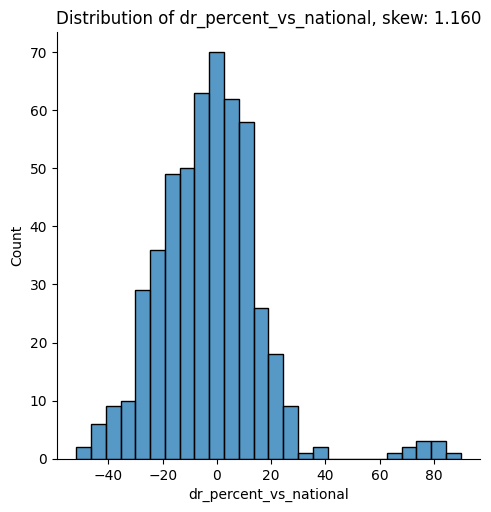

In [80]:
sns.displot(y).set(title='Distribution of '+y_col+', skew: '+str(y.skew())[:5])

In [81]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.1, random_state=42)
lm = LinearRegression()
lm.fit(X_train, y_train)
predicted = lm.predict(X_test)
print("Linear R^2 on training  data ",lm.score(X_train, y_train))
print("Linear R^2 on testing data ",lm.score(X_test,y_test))
print("Linear Median error on testing data ",median_absolute_error(y_true=y_test, y_pred=predicted))
print("Linear R^2 on 2020 data ",lm.score(X_2020,y_2020))
print("Linear Median error on 2020 data ",median_absolute_error(y_true=y_2020, y_pred=lm.predict(X_2020)))

Linear R^2 on training  data  0.8890534502523103
Linear R^2 on testing data  0.3128231575591811
Linear Median error on testing data  8.358784125927292
Linear R^2 on 2020 data  -9399621.448541488
Linear Median error on 2020 data  39467.81699529299


In [82]:
Input=[ ('polynomial', PolynomialFeatures(include_bias=False,degree=2)),('ss',StandardScaler() ), ('model',Lasso(alpha=1, tol = 0.3))]
las_pipe = Pipeline(Input)
las_pipe.fit(X_train, y_train)
las_pred=las_pipe.predict(X_test)
print("LASSO R^2 on training  data ",las_pipe.score(X_train, y_train))
print("LASSO R^2 on testing data ",las_pipe.score(X_test,y_test))
print("LASSO Median error on testing data ",median_absolute_error(y_true=y_test, y_pred=las_pred))
print("LASSO R^2 on 2020 data ",las_pipe.score(X_2020,y_2020))
print("LASSO Median error on 2020 data ",median_absolute_error(y_true=y_2020, y_pred=las_pipe.predict(X_2020)))

LASSO R^2 on training  data  0.7354201448407685
LASSO R^2 on testing data  0.4936689071247462
LASSO Median error on testing data  8.141999083744185
LASSO R^2 on 2020 data  0.4684332346821509
LASSO Median error on 2020 data  10.747273239290486


In [83]:
las_pipe.fit(X, y)
print("Lasso fit on all data R^2 on 2020 data ",las_pipe.score(X_2020,y_2020))
print("Lasso fit on all data Median error on 2020 data ",median_absolute_error(y_true=y_2020, y_pred=las_pipe.predict(X_2020)))

Lasso fit on all data R^2 on 2020 data  0.5657580917472609
Lasso fit on all data Median error on 2020 data  10.90670105411396


In [84]:
kf = KFold(shuffle=True, random_state=72018, n_splits=10)
param_grid = {
    "polynomial__degree": [1, 2],
    "model__alpha":[0.01,0.1,1,10, 20]
}
las_search = GridSearchCV(las_pipe, param_grid, n_jobs=2, cv=kf)
las_search.fit(X, y)
pd.DataFrame(las_search.cv_results_).sort_values(by='mean_test_score',ascending=False).head()

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
5       0.734132      0.030922         0.032423        0.004894   
4       0.010265      0.000352         0.004025        0.004930   
2       0.011211      0.003006         0.004026        0.004931   
0       0.014092      0.004932         0.000000        0.000000   
7       0.785755      0.029166         0.033023        0.006665   

  param_model__alpha param_polynomial__degree  \
5                  1                        2   
4                  1                        1   
2                0.1                        1   
0               0.01                        1   
7                 10                        2   

                                            params  split0_test_score  \
5     {'model__alpha': 1, 'polynomial__degree': 2}           0.523714   
4     {'model__alpha': 1, 'polynomial__degree': 1}           0.525900   
2   {'model__alpha': 0.1, 'polynomial__degree': 1}           0.494215   
0  {'model__alpha': 0.01, 'polynomial__degree': 1}           0.482501   
7    {'model__alpha': 10, 'polynomial__degree': 2}           0.229199   

   split1_test_score  split2_test_score  split3_test_score  split4_test_score  \
5           0.677286           0.425712           0.609072           0.646438   
4           0.645273           0.373369           0.500018           0.549522   
2           0.635469           0.303100           0.492169           0.542347   
0           0.619921           0.202130           0.502190           0.531985   
7           0.201089           0.145830           0.202436           0.212558   

   split5_test_score  split6_test_score  split7_test_score  split8_test_score  \
5           0.532471           0.644174           0.248020           0.490156   
4           0.412928           0.604031           0.211403           0.250931   
2           0.131321           0.546382          -0.212955           0.230362   
0           0.150407           0.533188          -0.481816           0.207523   
7           0.178176           0.233743           0.085206           0.150952   

   split9_test_score  mean_test_score  std_test_score  rank_test_score  
5           0.534839         0.533188        0.121030                1  
4           0.393632         0.446701        0.136710                2  
2           0.435700         0.359811        0.242012                3  
0           0.433892         0.318192        0.308398                4  
7           0.189669         0.182886        0.042811                5

In [85]:
las_cv_pred=las_search.best_estimator_.predict(X_test)
print("Lasso CV Median error on testing data ",median_absolute_error(y_true=y_test, y_pred=las_cv_pred))
print("Lasso CV R^2 on 2020 data ",las_search.best_estimator_.score(X_2020,y_2020))
print("Lasso CV Median error on 2020 data ",median_absolute_error(y_true=y_2020, y_pred=las_search.best_estimator_.predict(X_2020)))

Lasso CV Median error on testing data  7.962990553413253
Lasso CV R^2 on 2020 data  0.5657580917472609
Lasso CV Median error on 2020 data  10.90670105411396


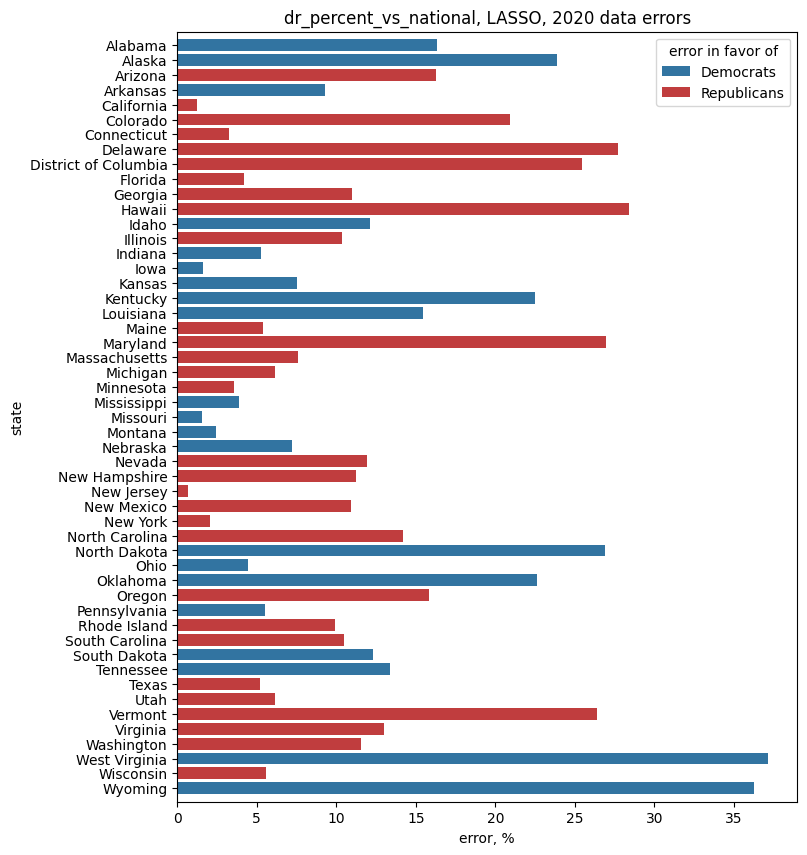

In [86]:
barplot_df=pd.DataFrame()
barplot_df['error, %']=las_search.best_estimator_.predict(X_2020)-y_2020
barplot_df['state']=data[data.year==2020].state
barplot_df['error in favor of']=np.where(barplot_df['error, %']>0,'Democrats','Republicans')
barplot_df['error, %']=np.abs(barplot_df['error, %'].to_numpy())
fig, ax=plt.subplots(figsize=(8,10))
ax=sns.barplot(data=barplot_df,
            x='error, %',
            y='state',
            hue='error in favor of',
            palette={'Republicans':'tab:red', 'Democrats':'tab:blue'},
            dodge=False)
ax.set(title=y_col+', LASSO, 2020 data errors')
ax.relim()
ax.autoscale_view()
ax.margins(y=0.01)

In [87]:
Input=[ ('polynomial', PolynomialFeatures(include_bias=False,degree=2)),('ss',StandardScaler() ), ('model',Ridge(alpha=1))]
ridge_pipe = Pipeline(Input)
ridge_pipe.fit(X_train, y_train)
ridge_pred=ridge_pipe.predict(X_test)
print("Ridge R^2 on training  data ",ridge_pipe.score(X_train, y_train))
print("Ridge R^2 on testing data ",ridge_pipe.score(X_test,y_test))
print("Ridge Median error on testing data ",median_absolute_error(y_true=y_test, y_pred=ridge_pred))
print("Ridge R^2 on 2020 data ",ridge_pipe.score(X_2020,y_2020))
print("Ridge Median error on 2020 data ",median_absolute_error(y_true=y_2020, y_pred=ridge_pipe.predict(X_2020)))

C:\Users\Jade\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\extmath.py:193: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


Ridge R^2 on training  data  0.9999984968116307
Ridge R^2 on testing data  0.35354661367458207
Ridge Median error on testing data  8.112460608149984
Ridge R^2 on 2020 data  -3151.012386037349
Ridge Median error on 2020 data  156.45761600521274


In [88]:
ridge_pipe.fit(X, y)
print("Ridge fit on all data R^2 on 2020 data ",ridge_pipe.score(X_2020,y_2020))
print("Ridge fit on all data Median error on 2020 data ",median_absolute_error(y_true=y_2020, y_pred=ridge_pipe.predict(X_2020)))

Ridge fit on all data R^2 on 2020 data  -1978.6437822258117
Ridge fit on all data Median error on 2020 data  115.90540296529767


C:\Users\Jade\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\extmath.py:193: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


In [89]:
kf = KFold(shuffle=True, random_state=72018, n_splits=10)
param_grid = {
    "polynomial__degree": [1, 2],
    "model__alpha":[0.01,0.1,1,10, 20, 50, 100, 200, 400, 500]
}
ridge_search = GridSearchCV(ridge_pipe, param_grid, n_jobs=2, cv=kf)
ridge_search.fit(X, y)
pd.DataFrame(ridge_search.cv_results_).sort_values(by='mean_test_score',ascending=False).head()

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
14       0.015525      0.005458         0.004641        0.004594   
16       0.013633      0.004374         0.000000        0.000000   
18       0.013716      0.004826         0.004323        0.004763   
12       0.013256      0.003962         0.004780        0.004704   
10       0.016489      0.003940         0.004025        0.004075   

   param_model__alpha param_polynomial__degree  \
14                200                        1   
16                400                        1   
18                500                        1   
12                100                        1   
10                 50                        1   

                                            params  split0_test_score  \
14  {'model__alpha': 200, 'polynomial__degree': 1}           0.567931   
16  {'model__alpha': 400, 'polynomial__degree': 1}           0.556206   
18  {'model__alpha': 500, 'polynomial__degree': 1}           0.548830   
12  {'model__alpha': 100, 'polynomial__degree': 1}           0.564092   
10   {'model__alpha': 50, 'polynomial__degree': 1}           0.547432   

    split1_test_score  split2_test_score  split3_test_score  \
14           0.670026           0.398897           0.508429   
16           0.633048           0.385171           0.478679   
18           0.616049           0.374827           0.468156   
12           0.687101           0.386515           0.537298   
10           0.690888           0.345927           0.565296   

    split4_test_score  split5_test_score  split6_test_score  \
14           0.599626           0.468798           0.619148   
16           0.582031           0.478886           0.595868   
18           0.572691           0.479704           0.585966   
12           0.605828           0.460482           0.636559   
10           0.608294           0.462740           0.651308   

    split7_test_score  split8_test_score  split9_test_score  mean_test_score  \
14           0.034865           0.314541           0.436250         0.461851   
16           0.140773           0.289300           0.450265         0.459023   
18           0.168809           0.281626           0.451153         0.454781   
12          -0.128417           0.342926           0.415486         0.450787   
10          -0.445871           0.370217           0.400530         0.419676   

    std_test_score  rank_test_score  
14        0.175832                1  
16        0.144909                2  
18        0.135990                3  
12        0.220748                4  
10        0.309772                5

In [90]:
ridge_cv_pred=ridge_search.best_estimator_.predict(X_test)
print("Median error on testing data ",median_absolute_error(y_true=y_test, y_pred=ridge_cv_pred))
print("R^2 on 2020 data ",ridge_search.best_estimator_.score(X_2020,y_2020))
print("Median error on 2020 data ",median_absolute_error(y_true=y_2020, y_pred=ridge_search.best_estimator_.predict(X_2020)))

Median error on testing data  9.59635423498065
R^2 on 2020 data  -8.761078691329473
Median error on 2020 data  69.91267681335492


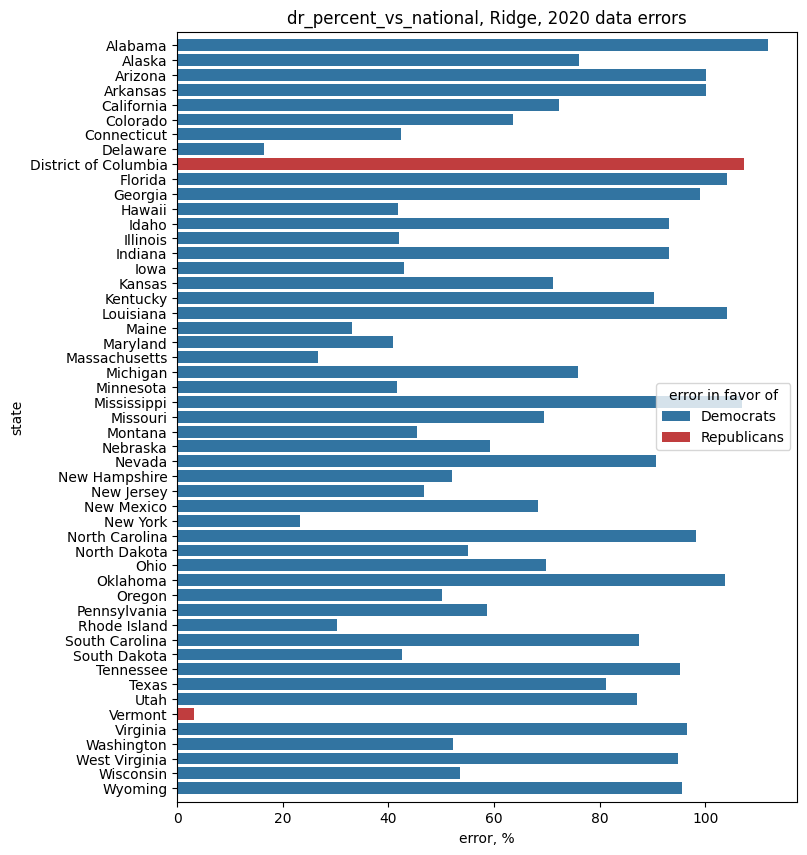

In [91]:
barplot_df=pd.DataFrame()
barplot_df['error, %']=ridge_search.best_estimator_.predict(X_2020)-y_2020
barplot_df['state']=data[data.year==2020].state
barplot_df['error in favor of']=np.where(barplot_df['error, %']>0,'Democrats','Republicans')
barplot_df['error, %']=np.abs(barplot_df['error, %'].to_numpy())
fig, ax=plt.subplots(figsize=(8,10))
ax=sns.barplot(data=barplot_df,
            x='error, %',
            y='state',
            hue='error in favor of',
            palette={'Republicans':'tab:red', 'Democrats':'tab:blue'},
            dodge=False)
ax.set(title=y_col+', Ridge, 2020 data errors')
ax.relim()
ax.autoscale_view()
ax.margins(y=0.01)

# d_percent_vs_national

In [92]:
y_col='d_percent_vs_national'
X=df.drop(columns=columns_to_predict)
y=df[y_col]
X_2020=df_2020.drop(columns=columns_to_predict)
y_2020=df_2020[y_col]

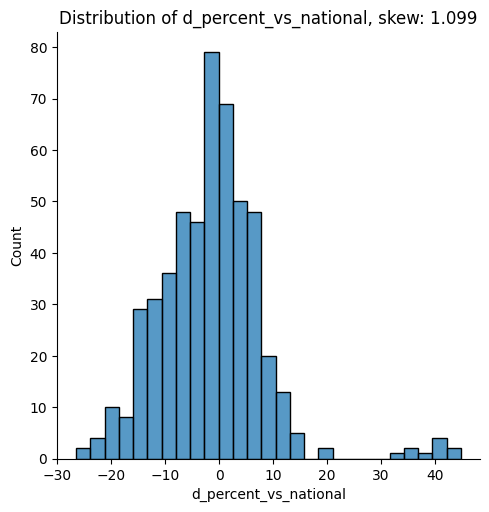

In [93]:
sns.displot(y).set(title='Distribution of '+y_col+', skew: '+str(y.skew())[:5])

In [94]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.1, random_state=42)
lm = LinearRegression()
lm.fit(X_train, y_train)
predicted = lm.predict(X_test)
print("Linear R^2 on training  data ",lm.score(X_train, y_train))
print("Linear R^2 on testing data ",lm.score(X_test,y_test))
print("Linear Median error on testing data ",median_absolute_error(y_true=y_test, y_pred=predicted))
print("Linear R^2 on 2020 data ",lm.score(X_2020,y_2020))
print("Linear Median error on 2020 data ",median_absolute_error(y_true=y_2020, y_pred=lm.predict(X_2020)))

Linear R^2 on training  data  0.8791218005818754
Linear R^2 on testing data  0.22726889955186724
Linear Median error on testing data  4.275568299532708
Linear R^2 on 2020 data  -18584770.71927991
Linear Median error on 2020 data  15788.272125509437


In [95]:
Input=[ ('polynomial', PolynomialFeatures(include_bias=False,degree=2)),('ss',StandardScaler() ), ('model',Lasso(alpha=1, tol = 0.3))]
las_pipe = Pipeline(Input)
las_pipe.fit(X_train, y_train)
las_pred=las_pipe.predict(X_test)
print("LASSO R^2 on training  data ",las_pipe.score(X_train, y_train))
print("LASSO R^2 on testing data ",las_pipe.score(X_test,y_test))
print("LASSO Median error on testing data ",median_absolute_error(y_true=y_test, y_pred=las_pred))
print("LASSO R^2 on 2020 data ",las_pipe.score(X_2020,y_2020))
print("LASSO Median error on 2020 data ",median_absolute_error(y_true=y_2020, y_pred=las_pipe.predict(X_2020)))

LASSO R^2 on training  data  0.6130541121695721
LASSO R^2 on testing data  0.4095663062870393
LASSO Median error on testing data  4.973806356065705
LASSO R^2 on 2020 data  0.565306556857806
LASSO Median error on 2020 data  4.9626144130455145


In [96]:
las_pipe.fit(X, y)
print("Lasso fit on all data R^2 on 2020 data ",las_pipe.score(X_2020,y_2020))
print("Lasso fit on all data Median error on 2020 data ",median_absolute_error(y_true=y_2020, y_pred=las_pipe.predict(X_2020)))

Lasso fit on all data R^2 on 2020 data  0.5727722523234833
Lasso fit on all data Median error on 2020 data  5.017064333799067


In [97]:
kf = KFold(shuffle=True, random_state=72018, n_splits=10)
param_grid = {
    "polynomial__degree": [1, 2],
    "model__alpha":[0.01,0.1,1,10, 20]
}
las_search = GridSearchCV(las_pipe, param_grid, n_jobs=2, cv=kf)
las_search.fit(X, y)
pd.DataFrame(las_search.cv_results_).sort_values(by='mean_test_score',ascending=False).head()

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
5       0.759549      0.031439         0.032473        0.003540   
4       0.013140      0.004777         0.002500        0.003604   
2       0.011234      0.000959         0.004681        0.003116   
0       0.016528      0.003538         0.002345        0.002332   
3       0.711978      0.045413         0.033858        0.007341   

  param_model__alpha param_polynomial__degree  \
5                  1                        2   
4                  1                        1   
2                0.1                        1   
0               0.01                        1   
3                0.1                        2   

                                            params  split0_test_score  \
5     {'model__alpha': 1, 'polynomial__degree': 2}           0.517922   
4     {'model__alpha': 1, 'polynomial__degree': 1}           0.505140   
2   {'model__alpha': 0.1, 'polynomial__degree': 1}           0.451906   
0  {'model__alpha': 0.01, 'polynomial__degree': 1}           0.445838   
3   {'model__alpha': 0.1, 'polynomial__degree': 2}           0.432863   

   split1_test_score  split2_test_score  split3_test_score  split4_test_score  \
5           0.669949           0.371580           0.575260           0.591717   
4           0.650165           0.314236           0.547886           0.545224   
2           0.624011           0.440417           0.492142           0.510514   
0           0.622763           0.261812           0.509516           0.502355   
3          -2.206531           0.491449           0.658074           0.566828   

   split5_test_score  split6_test_score  split7_test_score  split8_test_score  \
5           0.476723           0.598398           0.200175           0.416585   
4           0.367705           0.547127           0.158075           0.347816   
2           0.065748           0.538463          -0.063405           0.256563   
0           0.043429           0.516194          -0.475813           0.238870   
3           0.425051           0.615216          -0.133212           0.558717   

   split9_test_score  mean_test_score  std_test_score  rank_test_score  
5           0.442645         0.486095        0.129694                1  
4           0.365476         0.434885        0.140326                2  
2           0.423546         0.373990        0.208619                3  
0           0.428736         0.309370        0.307512                4  
3           0.563608         0.197206        0.828845                5

In [98]:
las_cv_pred=las_search.best_estimator_.predict(X_test)
print("Lasso CV Median error on testing data ",median_absolute_error(y_true=y_test, y_pred=las_cv_pred))
print("Lasso CV R^2 on 2020 data ",las_search.best_estimator_.score(X_2020,y_2020))
print("Lasso CV Median error on 2020 data ",median_absolute_error(y_true=y_2020, y_pred=las_search.best_estimator_.predict(X_2020)))

Lasso CV Median error on testing data  4.868372609083803
Lasso CV R^2 on 2020 data  0.5727722523234833
Lasso CV Median error on 2020 data  5.017064333799067


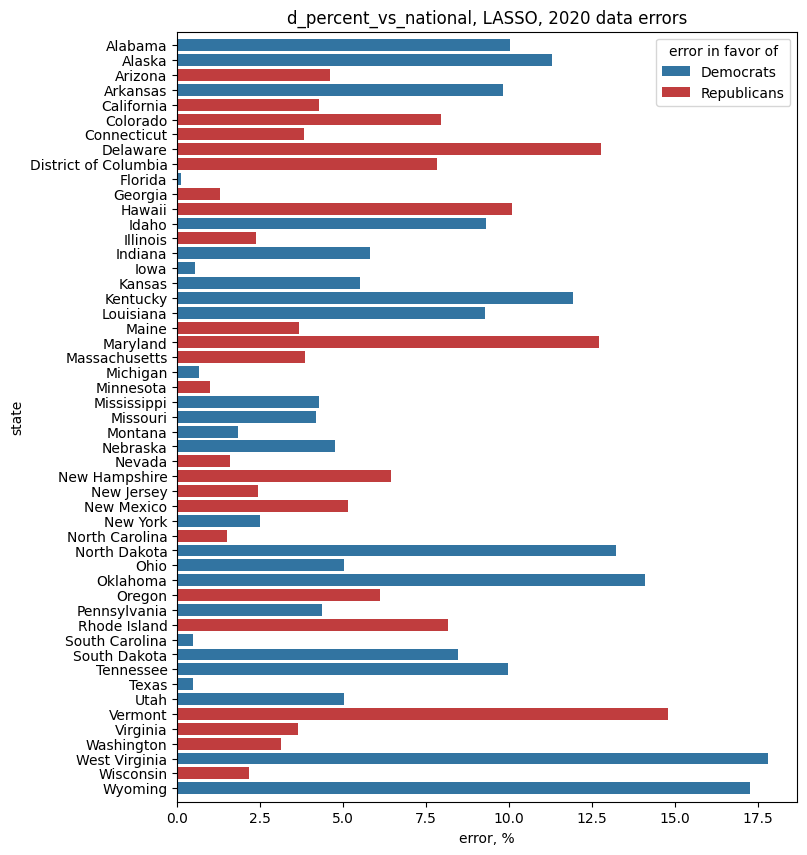

In [99]:
barplot_df=pd.DataFrame()
barplot_df['error, %']=las_search.best_estimator_.predict(X_2020)-y_2020
barplot_df['state']=data[data.year==2020].state
barplot_df['error in favor of']=np.where(barplot_df['error, %']>0,'Democrats','Republicans')
barplot_df['error, %']=np.abs(barplot_df['error, %'].to_numpy())
fig, ax=plt.subplots(figsize=(8,10))
ax=sns.barplot(data=barplot_df,
            x='error, %',
            y='state',
            hue='error in favor of',
            palette={'Republicans':'tab:red', 'Democrats':'tab:blue'},
            dodge=False)
ax.set(title=y_col+', LASSO, 2020 data errors')
ax.relim()
ax.autoscale_view()
ax.margins(y=0.01)

In [100]:
Input=[ ('polynomial', PolynomialFeatures(include_bias=False,degree=2)),('ss',StandardScaler() ), ('model',Ridge(alpha=1))]
ridge_pipe = Pipeline(Input)
ridge_pipe.fit(X_train, y_train)
ridge_pred=ridge_pipe.predict(X_test)
print("Ridge R^2 on training  data ",ridge_pipe.score(X_train, y_train))
print("Ridge R^2 on testing data ",ridge_pipe.score(X_test,y_test))
print("Ridge Median error on testing data ",median_absolute_error(y_true=y_test, y_pred=ridge_pred))
print("Ridge R^2 on 2020 data ",ridge_pipe.score(X_2020,y_2020))
print("Ridge Median error on 2020 data ",median_absolute_error(y_true=y_2020, y_pred=ridge_pipe.predict(X_2020)))

C:\Users\Jade\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\extmath.py:193: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


Ridge R^2 on training  data  0.9999985050012471
Ridge R^2 on testing data  0.41169416329397723
Ridge Median error on testing data  3.667550097034601
Ridge R^2 on 2020 data  -3772.105577443055
Ridge Median error on 2020 data  69.68823274886716


In [101]:
ridge_pipe.fit(X, y)
print("Ridge fit on all data R^2 on 2020 data ",ridge_pipe.score(X_2020,y_2020))
print("Ridge fit on all data Median error on 2020 data ",median_absolute_error(y_true=y_2020, y_pred=ridge_pipe.predict(X_2020)))

Ridge fit on all data R^2 on 2020 data  -2562.482680563439
Ridge fit on all data Median error on 2020 data  51.10778918368617


C:\Users\Jade\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\extmath.py:193: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


In [102]:
kf = KFold(shuffle=True, random_state=72018, n_splits=10)
param_grid = {
    "polynomial__degree": [1, 2],
    "model__alpha":[0.01,0.1,1,10, 20, 50, 100, 200, 400, 500]
}
ridge_search = GridSearchCV(ridge_pipe, param_grid, n_jobs=2, cv=kf)
ridge_search.fit(X, y)
pd.DataFrame(ridge_search.cv_results_).sort_values(by='mean_test_score',ascending=False).head()

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
14       0.016402      0.004782         0.003083        0.004712   
16       0.015500      0.004984         0.004146        0.005088   
18       0.017307      0.004728         0.004045        0.004955   
12       0.013671      0.004809         0.003153        0.004830   
10       0.012134      0.004128         0.004375        0.005372   

   param_model__alpha param_polynomial__degree  \
14                200                        1   
16                400                        1   
18                500                        1   
12                100                        1   
10                 50                        1   

                                            params  split0_test_score  \
14  {'model__alpha': 200, 'polynomial__degree': 1}           0.535405   
16  {'model__alpha': 400, 'polynomial__degree': 1}           0.521468   
18  {'model__alpha': 500, 'polynomial__degree': 1}           0.513537   
12  {'model__alpha': 100, 'polynomial__degree': 1}           0.534296   
10   {'model__alpha': 50, 'polynomial__degree': 1}           0.521166   

    split1_test_score  split2_test_score  split3_test_score  \
14           0.658315           0.423284           0.514766   
16           0.615924           0.407754           0.486830   
18           0.597349           0.396858           0.476921   
12           0.681382           0.414669           0.543158   
10           0.691836           0.381582           0.572438   

    split4_test_score  split5_test_score  split6_test_score  \
14           0.572793           0.377165           0.609655   
16           0.553349           0.398650           0.585053   
18           0.543368           0.403498           0.574857   
12           0.580368           0.359384           0.628902   
10           0.583804           0.354410           0.645185   

    split7_test_score  split8_test_score  split9_test_score  mean_test_score  \
14          -0.103860           0.320741           0.427211         0.433548   
16           0.040762           0.285898           0.439221         0.433491   
18           0.080006           0.274632           0.439206         0.430023   
12          -0.313995           0.352932           0.407141         0.418824   
10          -0.691601           0.375361           0.391497         0.382568   

    std_test_score  rank_test_score  
14        0.205609                1  
16        0.160976                2  
18        0.148169                3  
12        0.267023                4  
10        0.376183                5

In [103]:
ridge_cv_pred=ridge_search.best_estimator_.predict(X_test)
print("Median error on testing data ",median_absolute_error(y_true=y_test, y_pred=ridge_cv_pred))
print("R^2 on 2020 data ",ridge_search.best_estimator_.score(X_2020,y_2020))
print("Median error on 2020 data ",median_absolute_error(y_true=y_2020, y_pred=ridge_search.best_estimator_.predict(X_2020)))

Median error on testing data  4.151284453982529
R^2 on 2020 data  -11.321072589022462
Median error on 2020 data  40.263228691152605


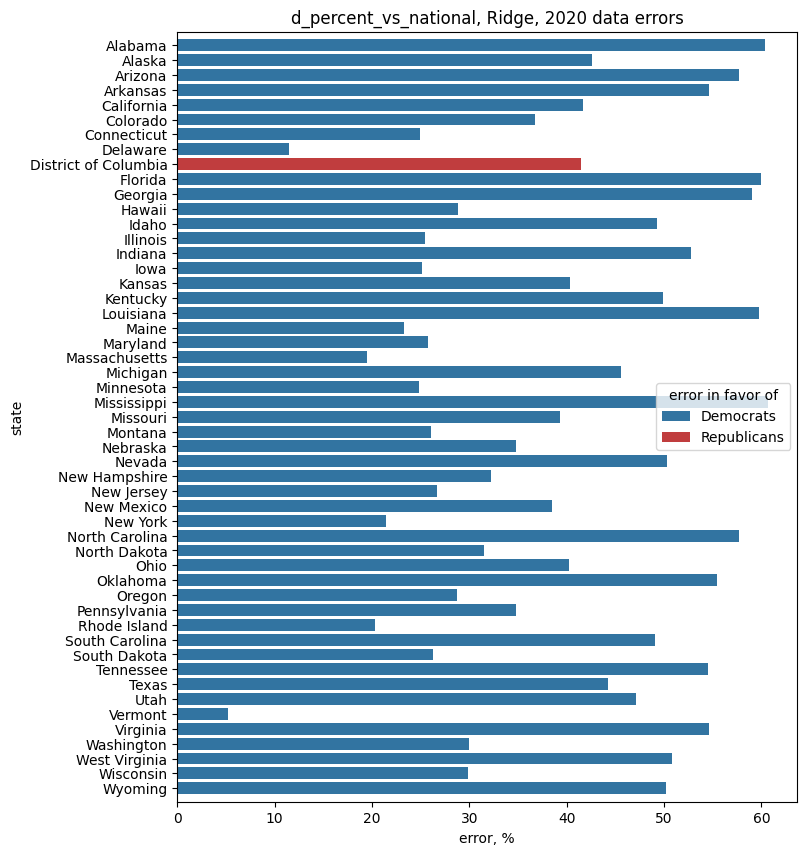

In [104]:
barplot_df=pd.DataFrame()
barplot_df['error, %']=ridge_search.best_estimator_.predict(X_2020)-y_2020
barplot_df['state']=data[data.year==2020].state
barplot_df['error in favor of']=np.where(barplot_df['error, %']>0,'Democrats','Republicans')
barplot_df['error, %']=np.abs(barplot_df['error, %'].to_numpy())
fig, ax=plt.subplots(figsize=(8,10))
ax=sns.barplot(data=barplot_df,
            x='error, %',
            y='state',
            hue='error in favor of',
            palette={'Republicans':'tab:red', 'Democrats':'tab:blue'},
            dodge=False)
ax.set(title=y_col+', Ridge, 2020 data errors')
ax.relim()
ax.autoscale_view()
ax.margins(y=0.01)

# r_percent_vs_national

In [105]:
y_col='r_percent_vs_national'
X=df.drop(columns=columns_to_predict)
y=df[y_col]
X_2020=df_2020.drop(columns=columns_to_predict)
y_2020=df_2020[y_col]

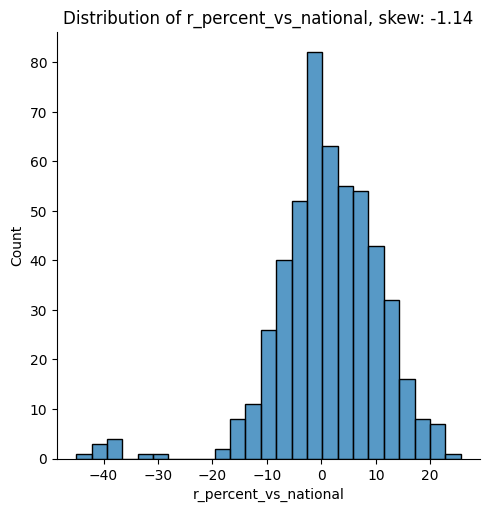

In [106]:
sns.displot(y).set(title='Distribution of '+y_col+', skew: '+str(y.skew())[:5])

In [107]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.1, random_state=42)
lm = LinearRegression()
lm.fit(X_train, y_train)
predicted = lm.predict(X_test)
print("Linear R^2 on training  data ",lm.score(X_train, y_train))
print("Linear R^2 on testing data ",lm.score(X_test,y_test))
print("Linear Median error on testing data ",median_absolute_error(y_true=y_test, y_pred=predicted))
print("Linear R^2 on 2020 data ",lm.score(X_2020,y_2020))
print("Linear Median error on 2020 data ",median_absolute_error(y_true=y_2020, y_pred=lm.predict(X_2020)))

Linear R^2 on training  data  0.8925935805924422
Linear R^2 on testing data  0.3632998504241156
Linear Median error on testing data  4.496404724610251
Linear R^2 on 2020 data  -89730273.64382227
Linear Median error on 2020 data  32759.24758065072


In [108]:
Input=[ ('polynomial', PolynomialFeatures(include_bias=False,degree=2)),('ss',StandardScaler() ), ('model',Lasso(alpha=1, tol = 0.3))]
las_pipe = Pipeline(Input)
las_pipe.fit(X_train, y_train)
las_pred=las_pipe.predict(X_test)
print("LASSO R^2 on training  data ",las_pipe.score(X_train, y_train))
print("LASSO R^2 on testing data ",las_pipe.score(X_test,y_test))
print("LASSO Median error on testing data ",median_absolute_error(y_true=y_test, y_pred=las_pred))
print("LASSO R^2 on 2020 data ",las_pipe.score(X_2020,y_2020))
print("LASSO Median error on 2020 data ",median_absolute_error(y_true=y_2020, y_pred=las_pipe.predict(X_2020)))

LASSO R^2 on training  data  0.6183735543522042
LASSO R^2 on testing data  0.3271024193044212
LASSO Median error on testing data  5.913906098986085
LASSO R^2 on 2020 data  0.5796347254188388
LASSO Median error on 2020 data  5.012725431684798


In [109]:
las_pipe.fit(X, y)
print("Lasso fit on all data R^2 on 2020 data ",las_pipe.score(X_2020,y_2020))
print("Lasso fit on all data Median error on 2020 data ",median_absolute_error(y_true=y_2020, y_pred=las_pipe.predict(X_2020)))

Lasso fit on all data R^2 on 2020 data  0.5872439047750089
Lasso fit on all data Median error on 2020 data  4.957084648118275


In [110]:
kf = KFold(shuffle=True, random_state=72018, n_splits=10)
param_grid = {
    "polynomial__degree": [1, 2],
    "model__alpha":[0.01,0.1,1,10, 20]
}
las_search = GridSearchCV(las_pipe, param_grid, n_jobs=2, cv=kf)
las_search.fit(X, y)
pd.DataFrame(las_search.cv_results_).sort_values(by='mean_test_score',ascending=False).head()

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
5       0.765470      0.023845         0.027896        0.003779   
4       0.011160      0.002992         0.003038        0.004640   
2       0.011088      0.003014         0.003020        0.004614   
0       0.016157      0.004679         0.004394        0.001554   
3       0.692042      0.010057         0.029060        0.004962   

  param_model__alpha param_polynomial__degree  \
5                  1                        2   
4                  1                        1   
2                0.1                        1   
0               0.01                        1   
3                0.1                        2   

                                            params  split0_test_score  \
5     {'model__alpha': 1, 'polynomial__degree': 2}           0.568246   
4     {'model__alpha': 1, 'polynomial__degree': 1}           0.556134   
2   {'model__alpha': 0.1, 'polynomial__degree': 1}           0.538939   
0  {'model__alpha': 0.01, 'polynomial__degree': 1}           0.512956   
3   {'model__alpha': 0.1, 'polynomial__degree': 2}           0.479053   

   split1_test_score  split2_test_score  split3_test_score  split4_test_score  \
5           0.640877           0.277530           0.552550           0.657669   
4           0.613169           0.304714           0.517881           0.579750   
2           0.632698           0.346041           0.436384           0.569960   
0           0.609533           0.162746           0.458442           0.553720   
3          -1.309054           0.383537           0.595456           0.626976   

   split5_test_score  split6_test_score  split7_test_score  split8_test_score  \
5           0.537977           0.608420           0.299123           0.351702   
4           0.444785           0.558638           0.160204           0.302212   
2           0.274393           0.555772           0.153084           0.248285   
0           0.255563           0.537213          -0.366172           0.169462   
3           0.383428           0.573295          -0.117616           0.498366   

   split9_test_score  mean_test_score  std_test_score  rank_test_score  
5           0.413786         0.490788        0.135552                1  
4           0.379265         0.441675        0.142268                2  
2           0.436016         0.419157        0.151072                3  
0           0.437007         0.333047        0.278639                4  
3           0.560744         0.267418        0.563478                5

In [111]:
las_cv_pred=las_search.best_estimator_.predict(X_test)
print("Lasso CV Median error on testing data ",median_absolute_error(y_true=y_test, y_pred=las_cv_pred))
print("Lasso CV R^2 on 2020 data ",las_search.best_estimator_.score(X_2020,y_2020))
print("Lasso CV Median error on 2020 data ",median_absolute_error(y_true=y_2020, y_pred=las_search.best_estimator_.predict(X_2020)))

Lasso CV Median error on testing data  5.73472267354459
Lasso CV R^2 on 2020 data  0.5872439047750089
Lasso CV Median error on 2020 data  4.957084648118275


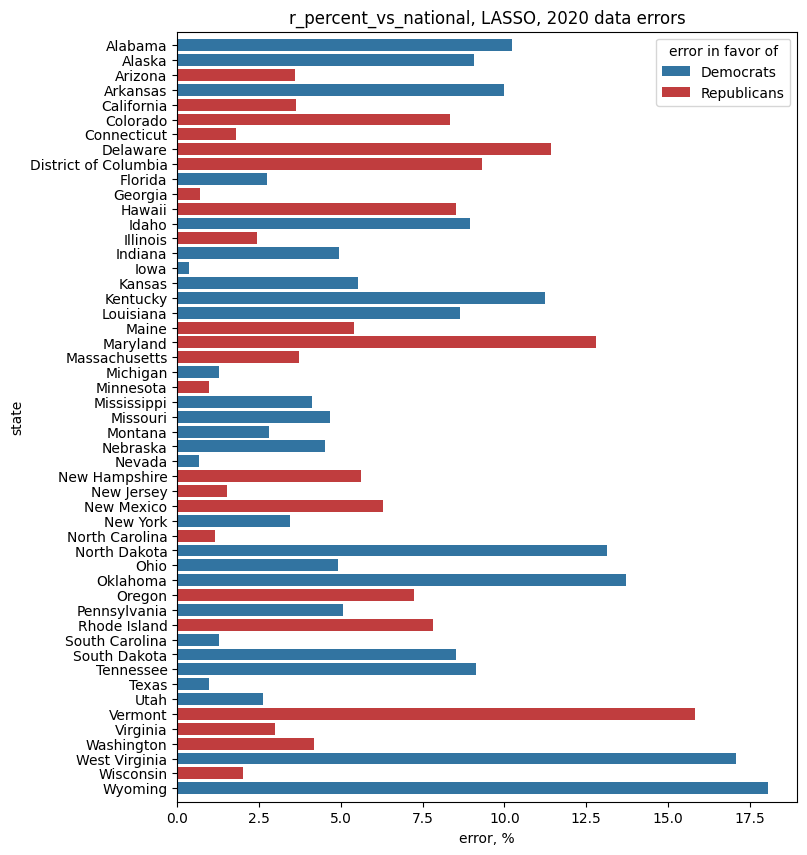

In [112]:
barplot_df=pd.DataFrame()
barplot_df['error, %']=las_search.best_estimator_.predict(X_2020)-y_2020
barplot_df['state']=data[data.year==2020].state
barplot_df['error in favor of']=np.where(barplot_df['error, %']<0,'Democrats','Republicans')
barplot_df['error, %']=np.abs(barplot_df['error, %'].to_numpy())
fig, ax=plt.subplots(figsize=(8,10))
ax=sns.barplot(data=barplot_df,
            x='error, %',
            y='state',
            hue='error in favor of',
            palette={'Republicans':'tab:red', 'Democrats':'tab:blue'},
            dodge=False)
ax.set(title=y_col+', LASSO, 2020 data errors')
ax.relim()
ax.autoscale_view()
ax.margins(y=0.01)

In [113]:
Input=[ ('polynomial', PolynomialFeatures(include_bias=False,degree=2)),('ss',StandardScaler() ), ('model',Ridge(alpha=1))]
ridge_pipe = Pipeline(Input)
ridge_pipe.fit(X_train, y_train)
ridge_pred=ridge_pipe.predict(X_test)
print("Ridge R^2 on training  data ",ridge_pipe.score(X_train, y_train))
print("Ridge R^2 on testing data ",ridge_pipe.score(X_test,y_test))
print("Ridge Median error on testing data ",median_absolute_error(y_true=y_test, y_pred=ridge_pred))
print("Ridge R^2 on 2020 data ",ridge_pipe.score(X_2020,y_2020))
print("Ridge Median error on 2020 data ",median_absolute_error(y_true=y_2020, y_pred=ridge_pipe.predict(X_2020)))

C:\Users\Jade\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\extmath.py:193: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


Ridge R^2 on training  data  0.9999984147723973
Ridge R^2 on testing data  0.2777744595840157
Ridge Median error on testing data  3.8365344682941998
Ridge R^2 on 2020 data  -2595.4119257157977
Ridge Median error on 2020 data  81.84627634877472


In [114]:
ridge_pipe.fit(X, y)
print("Ridge fit on all data R^2 on 2020 data ",ridge_pipe.score(X_2020,y_2020))
print("Ridge fit on all data Median error on 2020 data ",median_absolute_error(y_true=y_2020, y_pred=ridge_pipe.predict(X_2020)))

Ridge fit on all data R^2 on 2020 data  -1477.8655540420839
Ridge fit on all data Median error on 2020 data  60.829936071121786


C:\Users\Jade\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\extmath.py:193: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


In [115]:
kf = KFold(shuffle=True, random_state=72018, n_splits=10)
param_grid = {
    "polynomial__degree": [1, 2],
    "model__alpha":[0.01,0.1,1,10, 20, 50, 100, 200, 400, 500]
}
ridge_search = GridSearchCV(ridge_pipe, param_grid, n_jobs=2, cv=kf)
ridge_search.fit(X, y)
pd.DataFrame(ridge_search.cv_results_).sort_values(by='mean_test_score',ascending=False).head()

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
14       0.017583      0.004243         0.004029        0.004934   
16       0.017252      0.004711         0.005060        0.005061   
12       0.012220      0.003957         0.006032        0.004925   
18       0.011439      0.002958         0.004028        0.004933   
10       0.015371      0.005299         0.002611        0.003745   

   param_model__alpha param_polynomial__degree  \
14                200                        1   
16                400                        1   
12                100                        1   
18                500                        1   
10                 50                        1   

                                            params  split0_test_score  \
14  {'model__alpha': 200, 'polynomial__degree': 1}           0.591752   
16  {'model__alpha': 400, 'polynomial__degree': 1}           0.583465   
12  {'model__alpha': 100, 'polynomial__degree': 1}           0.583318   
18  {'model__alpha': 500, 'polynomial__degree': 1}           0.576879   
10   {'model__alpha': 50, 'polynomial__degree': 1}           0.560689   

    split1_test_score  split2_test_score  split3_test_score  \
14           0.668625           0.369796           0.466548   
16           0.637605           0.359303           0.437161   
12           0.678952           0.352293           0.494119   
18           0.622373           0.349978           0.426843   
10           0.675135           0.303200           0.519403   

    split4_test_score  split5_test_score  split6_test_score  \
14           0.618809           0.548365           0.609756   
16           0.602497           0.546060           0.588154   
12           0.623844           0.549082           0.624489   
18           0.593601           0.542341           0.578636   
10           0.624948           0.556311           0.636212   

    split7_test_score  split8_test_score  split9_test_score  mean_test_score  \
14           0.173365           0.290659           0.443429         0.478110   
16           0.237780           0.277707           0.458150         0.472788   
12           0.061973           0.311030           0.423156         0.470226   
18           0.253741           0.274111           0.459555         0.467806   
10          -0.181969           0.338598           0.409496         0.444202   

    std_test_score  rank_test_score  
14        0.152430                1  
16        0.135116                2  
12        0.178516                3  
18        0.129777                4  
10        0.240622                5

In [116]:
ridge_cv_pred=ridge_search.best_estimator_.predict(X_test)
print("Median error on testing data ",median_absolute_error(y_true=y_test, y_pred=ridge_cv_pred))
print("R^2 on 2020 data ",ridge_search.best_estimator_.score(X_2020,y_2020))
print("Median error on 2020 data ",median_absolute_error(y_true=y_2020, y_pred=ridge_search.best_estimator_.predict(X_2020)))

Median error on testing data  4.40854236301766
R^2 on 2020 data  -6.646683740380577
Median error on 2020 data  30.17050463343638


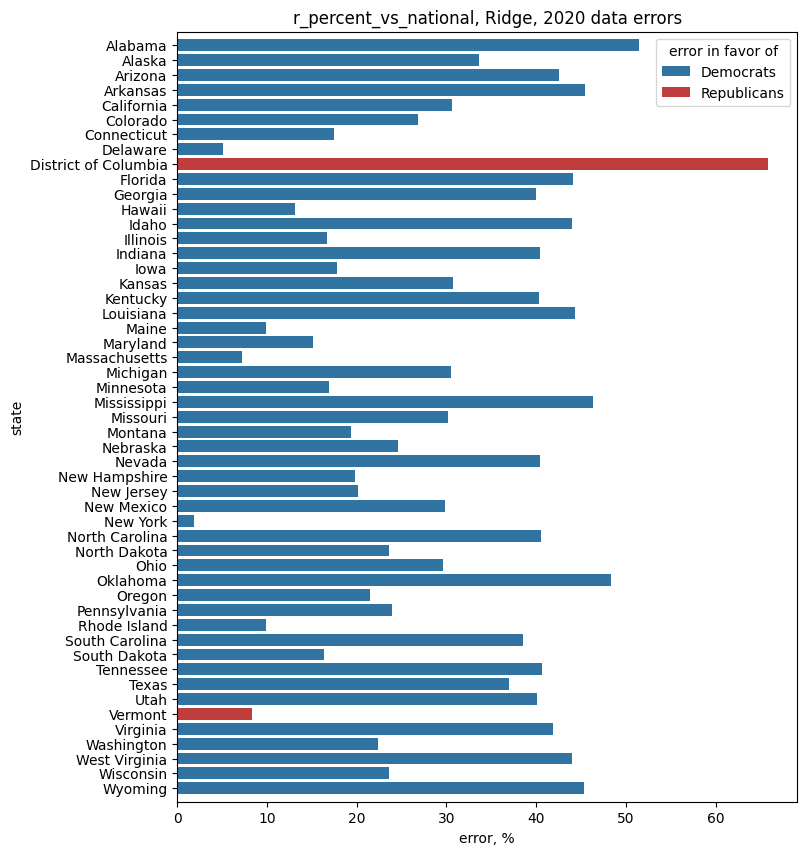

In [117]:
barplot_df=pd.DataFrame()
barplot_df['error, %']=ridge_search.best_estimator_.predict(X_2020)-y_2020
barplot_df['state']=data[data.year==2020].state
barplot_df['error in favor of']=np.where(barplot_df['error, %']<0,'Democrats','Republicans')
barplot_df['error, %']=np.abs(barplot_df['error, %'].to_numpy())
fig, ax=plt.subplots(figsize=(8,10))
ax=sns.barplot(data=barplot_df,
            x='error, %',
            y='state',
            hue='error in favor of',
            palette={'Republicans':'tab:red', 'Democrats':'tab:blue'},
            dodge=False)
ax.set(title=y_col+', Ridge, 2020 data errors')
ax.relim()
ax.autoscale_view()
ax.margins(y=0.01)

# dr_swing_vs_national

In [118]:
y_col='dr_swing_vs_national'
X=df.drop(columns=columns_to_predict)
y=df[y_col]
X_2020=df_2020.drop(columns=columns_to_predict)
y_2020=df_2020[y_col]

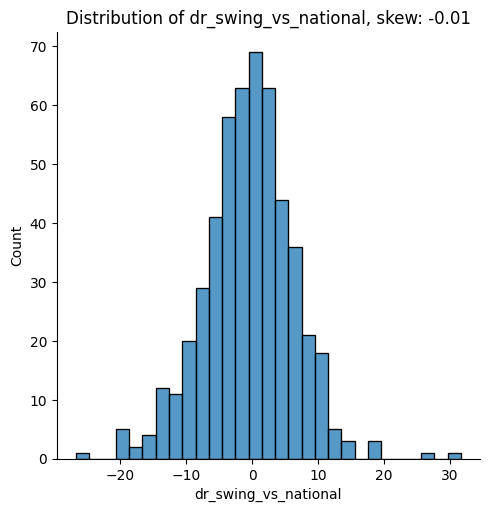

In [119]:
sns.displot(y).set(title='Distribution of '+y_col+', skew: '+str(y.skew())[:5])

In [120]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.1, random_state=42)
lm = LinearRegression()
lm.fit(X_train, y_train)
predicted = lm.predict(X_test)
print("Linear R^2 on training  data ",lm.score(X_train, y_train))
print("Linear R^2 on testing data ",lm.score(X_test,y_test))
print("Linear Median error on testing data ",median_absolute_error(y_true=y_test, y_pred=predicted))
print("Linear R^2 on 2020 data ",lm.score(X_2020,y_2020))
print("Linear Median error on 2020 data ",median_absolute_error(y_true=y_2020, y_pred=lm.predict(X_2020)))

Linear R^2 on training  data  0.6125165561291412
Linear R^2 on testing data  -0.10422964187555817
Linear Median error on testing data  6.0819983438627006
Linear R^2 on 2020 data  -21904202357.220825
Linear Median error on 2020 data  68461.81425871722


In [121]:
Input=[ ('polynomial', PolynomialFeatures(include_bias=False,degree=2)),('ss',StandardScaler() ), ('model',Lasso(alpha=1, tol = 0.3))]
las_pipe = Pipeline(Input)
las_pipe.fit(X_train, y_train)
las_pred=las_pipe.predict(X_test)
print("LASSO R^2 on training  data ",las_pipe.score(X_train, y_train))
print("LASSO R^2 on testing data ",las_pipe.score(X_test,y_test))
print("LASSO Median error on testing data ",median_absolute_error(y_true=y_test, y_pred=las_pred))
print("LASSO R^2 on 2020 data ",las_pipe.score(X_2020,y_2020))
print("LASSO Median error on 2020 data ",median_absolute_error(y_true=y_2020, y_pred=las_pipe.predict(X_2020)))

LASSO R^2 on training  data  0.14413560008660464
LASSO R^2 on testing data  -0.03212828479834817
LASSO Median error on testing data  4.076204005751875
LASSO R^2 on 2020 data  -0.34842733272687476
LASSO Median error on 2020 data  2.3619449700760144


In [122]:
las_pipe.fit(X, y)
print("Lasso fit on all data R^2 on 2020 data ",las_pipe.score(X_2020,y_2020))
print("Lasso fit on all data Median error on 2020 data ",median_absolute_error(y_true=y_2020, y_pred=las_pipe.predict(X_2020)))

Lasso fit on all data R^2 on 2020 data  -0.23856199532501
Lasso fit on all data Median error on 2020 data  2.226035447538435


In [123]:
kf = KFold(shuffle=True, random_state=72018, n_splits=10)
param_grid = {
    "polynomial__degree": [1, 2],
    "model__alpha":[0.01,0.1,1,10, 20]
}
las_search = GridSearchCV(las_pipe, param_grid, n_jobs=2, cv=kf)
las_search.fit(X, y)
pd.DataFrame(las_search.cv_results_).sort_values(by='mean_test_score',ascending=False).head()

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
5       0.723406      0.036414         0.028549        0.004235   
2       0.014735      0.003001         0.002930        0.003337   
4       0.011062      0.005405         0.004832        0.005984   
6       0.010394      0.000597         0.003029        0.004627   
7       0.708697      0.026592         0.027464        0.004788   

  param_model__alpha param_polynomial__degree  \
5                  1                        2   
2                0.1                        1   
4                  1                        1   
6                 10                        1   
7                 10                        2   

                                           params  split0_test_score  \
5    {'model__alpha': 1, 'polynomial__degree': 2}           0.096994   
2  {'model__alpha': 0.1, 'polynomial__degree': 1}           0.147388   
4    {'model__alpha': 1, 'polynomial__degree': 1}           0.035425   
6   {'model__alpha': 10, 'polynomial__degree': 1}          -0.002026   
7   {'model__alpha': 10, 'polynomial__degree': 2}          -0.002026   

   split1_test_score  split2_test_score  split3_test_score  split4_test_score  \
5           0.163419           0.003176          -0.052796           0.020692   
2           0.281137           0.110948          -0.145030           0.114403   
4           0.021914          -0.019720          -0.052032          -0.032907   
6          -0.000281          -0.008195          -0.017472          -0.034361   
7          -0.000281          -0.008195          -0.017472          -0.034361   

   split5_test_score  split6_test_score  split7_test_score  split8_test_score  \
5           0.062037          -0.034054           0.034282          -0.007150   
2          -0.059374           0.094200          -0.503108          -0.056822   
4           0.036303          -0.015213           0.003164          -0.025187   
6          -0.000085          -0.036126          -0.009548          -0.000151   
7          -0.000085          -0.036126          -0.009548          -0.000151   

   split9_test_score  mean_test_score  std_test_score  rank_test_score  
5           0.027509         0.031411        0.060386                1  
2           0.020773         0.000452        0.204051                2  
4           0.032698        -0.001556        0.030254                3  
6          -0.002747        -0.011099        0.013150                4  
7          -0.002747        -0.011099        0.013150                4

In [124]:
las_cv_pred=las_search.best_estimator_.predict(X_test)
print("Lasso CV Median error on testing data ",median_absolute_error(y_true=y_test, y_pred=las_cv_pred))
print("Lasso CV R^2 on 2020 data ",las_search.best_estimator_.score(X_2020,y_2020))
print("Lasso CV Median error on 2020 data ",median_absolute_error(y_true=y_2020, y_pred=las_search.best_estimator_.predict(X_2020)))

Lasso CV Median error on testing data  4.242877674639979
Lasso CV R^2 on 2020 data  -0.23856199532501
Lasso CV Median error on 2020 data  2.226035447538435


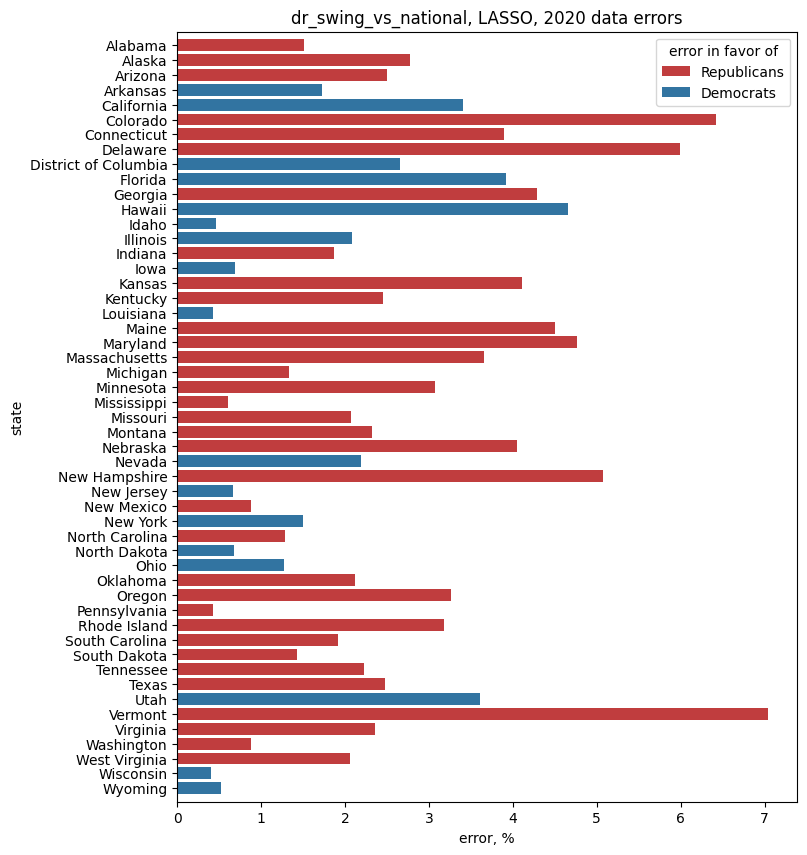

In [125]:
barplot_df=pd.DataFrame()
barplot_df['error, %']=las_search.best_estimator_.predict(X_2020)-y_2020
barplot_df['state']=data[data.year==2020].state
barplot_df['error in favor of']=np.where(barplot_df['error, %']>0,'Democrats','Republicans')
barplot_df['error, %']=np.abs(barplot_df['error, %'].to_numpy())
fig, ax=plt.subplots(figsize=(8,10))
ax=sns.barplot(data=barplot_df,
            x='error, %',
            y='state',
            hue='error in favor of',
            palette={'Republicans':'tab:red', 'Democrats':'tab:blue'},
            dodge=False)
ax.set(title=y_col+', LASSO, 2020 data errors')
ax.relim()
ax.autoscale_view()
ax.margins(y=0.01)

In [126]:
Input=[ ('polynomial', PolynomialFeatures(include_bias=False,degree=2)),('ss',StandardScaler() ), ('model',Ridge(alpha=1))]
ridge_pipe = Pipeline(Input)
ridge_pipe.fit(X_train, y_train)
ridge_pred=ridge_pipe.predict(X_test)
print("Ridge R^2 on training  data ",ridge_pipe.score(X_train, y_train))
print("Ridge R^2 on testing data ",ridge_pipe.score(X_test,y_test))
print("Ridge Median error on testing data ",median_absolute_error(y_true=y_test, y_pred=ridge_pred))
print("Ridge R^2 on 2020 data ",ridge_pipe.score(X_2020,y_2020))
print("Ridge Median error on 2020 data ",median_absolute_error(y_true=y_2020, y_pred=ridge_pipe.predict(X_2020)))

C:\Users\Jade\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\extmath.py:193: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


Ridge R^2 on training  data  0.9999955493851341
Ridge R^2 on testing data  -0.9919550968741333
Ridge Median error on testing data  5.837069274507728
Ridge R^2 on 2020 data  -13072.273187483683
Ridge Median error on 2020 data  165.18628744329877


In [127]:
ridge_pipe.fit(X, y)
print("Ridge fit on all data R^2 on 2020 data ",ridge_pipe.score(X_2020,y_2020))
print("Ridge fit on all data Median error on 2020 data ",median_absolute_error(y_true=y_2020, y_pred=ridge_pipe.predict(X_2020)))

Ridge fit on all data R^2 on 2020 data  -15298.92601612668
Ridge fit on all data Median error on 2020 data  158.6314664789543


C:\Users\Jade\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\extmath.py:193: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


In [128]:
kf = KFold(shuffle=True, random_state=72018, n_splits=10)
param_grid = {
    "polynomial__degree": [1, 2],
    "model__alpha":[100, 200, 400, 500, 600, 700, 800, 1000, 1200, 1500, 2000]
}
ridge_search = GridSearchCV(ridge_pipe, param_grid, n_jobs=2, cv=kf)
ridge_search.fit(X, y)
pd.DataFrame(ridge_search.cv_results_).sort_values(by='mean_test_score',ascending=False).head()

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
14       0.015329      0.005021         0.003085        0.004592   
16       0.012716      0.001651         0.000299        0.000898   
12       0.011069      0.003029         0.004630        0.005673   
10       0.014115      0.004946         0.002002        0.004003   
18       0.014315      0.005222         0.002005        0.004009   

   param_model__alpha param_polynomial__degree  \
14               1000                        1   
16               1200                        1   
12                800                        1   
10                700                        1   
18               1500                        1   

                                             params  split0_test_score  \
14  {'model__alpha': 1000, 'polynomial__degree': 1}           0.159619   
16  {'model__alpha': 1200, 'polynomial__degree': 1}           0.160032   
12   {'model__alpha': 800, 'polynomial__degree': 1}           0.157424   
10   {'model__alpha': 700, 'polynomial__degree': 1}           0.155195   
18  {'model__alpha': 1500, 'polynomial__degree': 1}           0.158922   

    split1_test_score  split2_test_score  split3_test_score  \
14           0.213042           0.188566          -0.081450   
16           0.200898           0.183660          -0.074710   
12           0.227877           0.192934          -0.090439   
10           0.236670           0.194551          -0.096198   
18           0.186129           0.176289          -0.067207   

    split4_test_score  split5_test_score  split6_test_score  \
14           0.139765           0.148300           0.118482   
16           0.135274           0.150228           0.111939   
12           0.143673           0.143686           0.125499   
10           0.145153           0.139714           0.129103   
18           0.128291           0.150434           0.103115   

    split7_test_score  split8_test_score  split9_test_score  mean_test_score  \
14           0.087600           0.012674           0.164203         0.115080   
16           0.099362           0.015623           0.162985         0.114529   
12           0.069409           0.009366           0.165005         0.114443   
10           0.056744           0.007570           0.165234         0.113374   
18           0.109712           0.019423           0.160579         0.112569   

    std_test_score  rank_test_score  
14        0.084252                1  
16        0.080120                2  
12        0.089616                3  
10        0.093007                4  
18        0.075299                5

In [129]:
ridge_cv_pred=ridge_search.best_estimator_.predict(X_test)
print("Median error on testing data ",median_absolute_error(y_true=y_test, y_pred=ridge_cv_pred))
print("R^2 on 2020 data ",ridge_search.best_estimator_.score(X_2020,y_2020))
print("Median error on 2020 data ",median_absolute_error(y_true=y_2020, y_pred=ridge_search.best_estimator_.predict(X_2020)))

Median error on testing data  4.2532253278194405
R^2 on 2020 data  -18.376566039656495
Median error on 2020 data  5.406177938900242


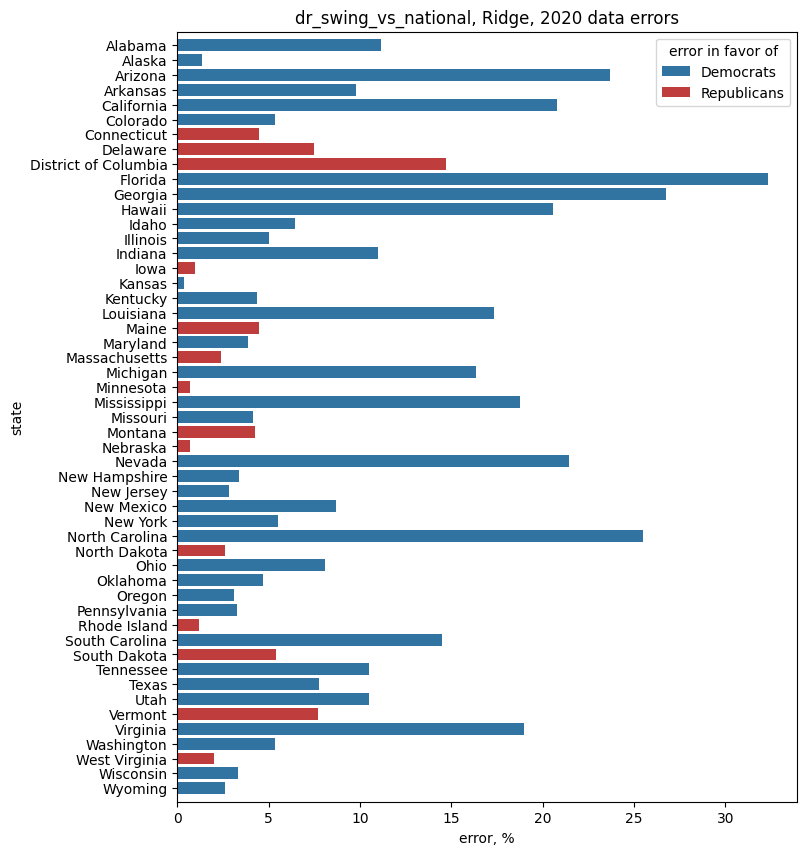

In [130]:
barplot_df=pd.DataFrame()
barplot_df['error, %']=ridge_search.best_estimator_.predict(X_2020)-y_2020
barplot_df['state']=data[data.year==2020].state
barplot_df['error in favor of']=np.where(barplot_df['error, %']>0,'Democrats','Republicans')
barplot_df['error, %']=np.abs(barplot_df['error, %'].to_numpy())
fig, ax=plt.subplots(figsize=(8,10))
ax=sns.barplot(data=barplot_df,
            x='error, %',
            y='state',
            hue='error in favor of',
            palette={'Republicans':'tab:red', 'Democrats':'tab:blue'},
            dodge=False)
ax.set(title=y_col+', Ridge, 2020 data errors')
ax.relim()
ax.autoscale_view()
ax.margins(y=0.01)

# Analysing the results

Out of all the models constructed, the best one by far is the Lasso model with alpha=1 and polynomial degree=2 predicting the dr_swing_vs_national target.

In [131]:
y_col='dr_swing_vs_national'
X=df.drop(columns=columns_to_predict)
y=df[y_col]
X_2020=df_2020.drop(columns=columns_to_predict)
y_2020=df_2020[y_col]

Input=[ ('polynomial', PolynomialFeatures(include_bias=False,degree=2)),
       ('ss',StandardScaler() ), 
       ('model',Lasso(alpha=1, tol = 0.3))]
las_pipe = Pipeline(Input)
las_pipe.fit(X, y)
print("Best model R^2 on 2020 data ",las_pipe.score(X_2020,y_2020))
print("Best model median absolute error on 2020 data ",median_absolute_error(y_true=y_2020, y_pred=las_pipe.predict(X_2020)))

Best model R^2 on 2020 data  -0.23856199532501
Best model median absolute error on 2020 data  2.226035447538435


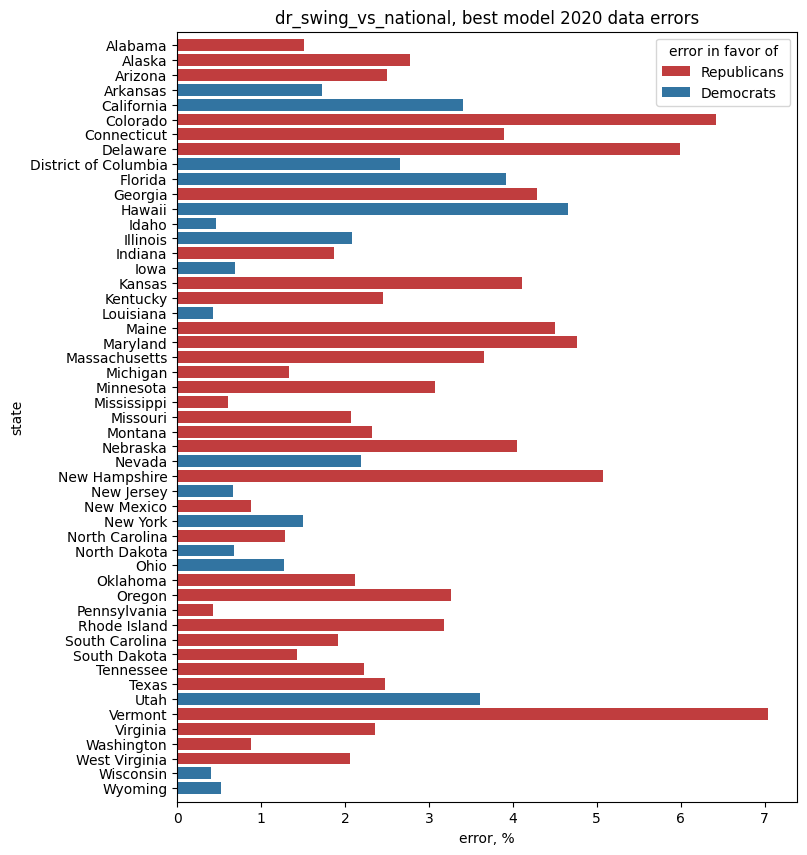

In [132]:
barplot_df=pd.DataFrame()
barplot_df['error, %']=las_pipe.predict(X_2020)-y_2020
barplot_df['state']=data[data.year==2020].state
barplot_df['error in favor of']=np.where(barplot_df['error, %']>0,'Democrats','Republicans')
barplot_df['error, %']=np.abs(barplot_df['error, %'].to_numpy())
fig, ax=plt.subplots(figsize=(8,10))
ax=sns.barplot(data=barplot_df,
            x='error, %',
            y='state',
            hue='error in favor of',
            palette={'Republicans':'tab:red', 'Democrats':'tab:blue'},
            dodge=False)
ax.set(title=y_col+', best model 2020 data errors')
ax.relim()
ax.autoscale_view()
ax.margins(y=0.01)

With the mean absolute value calculated to be 2.226 and the maximum absolute value just around 7 percent, as seen on the graph above, this model does a really good job at predicting the 2020 value while trained on 1980-2016 data, considering that many important features were left out of the dataset, as previously discussed. 

Let's look at features this Lasso model uses to come up with its' predictions.

In [133]:
df_feature_coefs = pd.DataFrame(zip(las_pipe.named_steps["polynomial"].get_feature_names_out(X.columns),
                 las_pipe.named_steps["model"].coef_,
))
df_feature_coefs.columns=['features', 'coefs']
df_feature_coefs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40185 entries, 0 to 40184
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   features  40185 non-null  object 
 1   coefs     40185 non-null  float64
dtypes: float64(1), object(1)
memory usage: 628.0+ KB


In [134]:
df_feature_coefs.describe()

coefs
count  40185.000000
mean       0.000010
std        0.003312
min       -0.301051
25%        0.000000
50%        0.000000
75%        0.000000
max        0.261331

In [135]:
nonzero_features=df_feature_coefs[df_feature_coefs.coefs!=0]
print('Number of polynomial features with non-zero coefficients: ',nonzero_features.shape[0])

Number of polynomial features with non-zero coefficients:  32


Among 40185 polynomial features, only 32 were actually used by the model, with the rest of coefficients zeroed out. Let's look at the list of these useful features.

In [136]:
nnonzero_features_list=nonzero_features.features.tolist()
nnonzero_features_list

['vn_4ych_Personal interest income, Millions of dollars 4ych_Excluding Social Security benefits, Thousands of dollars',
 "vn_4ych_Personal interest income, Millions of dollars 4ych_Workers' compensation, Thousands of dollars",
 'vn_4ych_Personal interest income, Millions of dollars 1ych_Earned Income Tax Credit (EITC), Thousands of dollars',
 'vn_4ych_Personal interest income, Millions of dollars r_winner_8y_ago',
 "vn_4ych_Monetary interest receipts, Millions of dollars 4ych_Workers' compensation, Thousands of dollars",
 'vn_Per capita personal income, Dollars 4ych_Per capita income maintenance benefits, Dollars',
 'vn_Per capita personal income, Dollars 1ych_Per capita dividends, Dollars',
 '1ych_Per capita net earnings, Dollars vn_Per capita dividends, interest, and rent, Dollars',
 '1ych_Per capita net earnings, Dollars vn_Per capita interest, Dollars',
 '1ych_Per capita net earnings, Dollars vn_Average wages and salaries, Dollars',
 'vn_Per capita net earnings, Dollars 4ych_Per ca

In [137]:
nonzero_features.sort_values(by='coefs')

features     coefs
13466  vn_4ych_Per capita dividends, interest, and re... -0.301051
28244  vn_4ych_Railroad retirement and disability ben... -0.253468
2348   vn_4ych_Personal interest income, Millions of ... -0.174725
2507   vn_4ych_Personal interest income, Millions of ... -0.149983
2385   vn_4ych_Personal interest income, Millions of ... -0.073727
2356   vn_4ych_Personal interest income, Millions of ... -0.056730
39279  vn_4ych_Nonfarm personal income, Millions of d... -0.047722
37408  vn_4ych_Veterans' life insurance benefits, Tho... -0.041614
4520   vn_4ych_Monetary interest receipts, Millions o... -0.016084
7316   vn_Per capita personal income, Dollars 1ych_Pe...  0.000733
8075   1ych_Per capita net earnings, Dollars vn_Per c...  0.002032
31061  vn_4ych_Public assistance medical care benefit...  0.003174
8313   vn_Per capita net earnings, Dollars 4ych_Per c...  0.003699
15607  4ych_Per capita rent, Dollars vn_4ych_Refundab...  0.011557
8083   1ych_Per capita net earnings, Dollars vn_Per c...  0.017506
9822   4ych_Per capita income maintenance benefits, D...  0.020340
19676  vn_4ych_Proprietors' income, Millions of dolla...  0.021169
31135  vn_4ych_Public assistance medical care benefit...  0.030370
9818   4ych_Per capita income maintenance benefits, D...  0.037140
8127   1ych_Per capita net earnings, Dollars vn_Avera...  0.038712
29400  vn_4ych_Other government retirement and disabi...  0.042438
15221  vn_4ych_Per capita interest, Dollars vn_4ych_E...  0.044844
19023  4ych_Proprietors' income, Millions of dollars ...  0.047940
33159  vn_4ych_Supplemental Nutrition Assistance Prog...  0.049335
11299  vn_Per capita unemployment insurance compensat...  0.050313
10777  vn_4ych_Per capita income maintenance benefits...  0.062721
7299   vn_Per capita personal income, Dollars 4ych_Pe...  0.099566
15004  vn_Per capita interest, Dollars 1ych_Proprieto...  0.105911
11356  vn_Per capita unemployment insurance compensat...  0.106238
30027  vn_4ych_Medical benefits, Thousands of dollars...  0.192785
28960  4ych_Other government retirement and disabilit...  0.248738
13184  vn_Per capita dividends, interest, and rent, D...  0.261331

Some of the coefficients are much smaller than others, but it doesn't necessarily mean they are less important. Let's get a list of all original features used to create these polynomial features.

In [138]:
starting_strings=['vn_', '1ych', '4ych', 'd_', 'r_', 'incumbent']
useful_features=[]
for feat in nnonzero_features_list:
    for s in starting_strings:
        find=feat.find(s,5)
        if (find!=-1):
            useful_features.append(feat[:find].strip())
            useful_features.append(feat[find:].strip())
            break

In [139]:
len(useful_features)

64

Leaving only unique values...

In [140]:
useful_features=pd.Series(useful_features).unique().tolist()

In [141]:
len(useful_features)

40

In [142]:
useful_features

['vn_4ych_Personal interest income, Millions of dollars',
 '4ych_Excluding Social Security benefits, Thousands of dollars',
 "4ych_Workers' compensation, Thousands of dollars",
 '1ych_Earned Income Tax Credit (EITC), Thousands of dollars',
 'r_winner_8y_ago',
 'vn_4ych_Monetary interest receipts, Millions of dollars',
 'vn_Per capita personal income, Dollars',
 '4ych_Per capita income maintenance benefits, Dollars',
 '1ych_Per capita dividends, Dollars',
 '1ych_Per capita net earnings, Dollars',
 'vn_Per capita dividends, interest, and rent, Dollars',
 'vn_Per capita interest, Dollars',
 'vn_Average wages and salaries, Dollars',
 'vn_Per capita net earnings, Dollars',
 'vn_Per capita dividends, Dollars',
 'vn_4ych_Per capita income maintenance benefits, Dollars',
 'r_winner_4y_ago',
 'vn_Per capita unemployment insurance compensation, Dollars',
 "4ych_Proprietors' income, Millions of dollars",
 '1ych_Other government retirement and disability insurance benefits, Thousands of dollars',


Let's look at the heatmap of correlations between these features and all 8 targets. 

In [143]:
cols_for_heatmap=useful_features
cols_for_heatmap.extend(columns_to_predict)

In [144]:
df_heatmap=data[cols_for_heatmap]

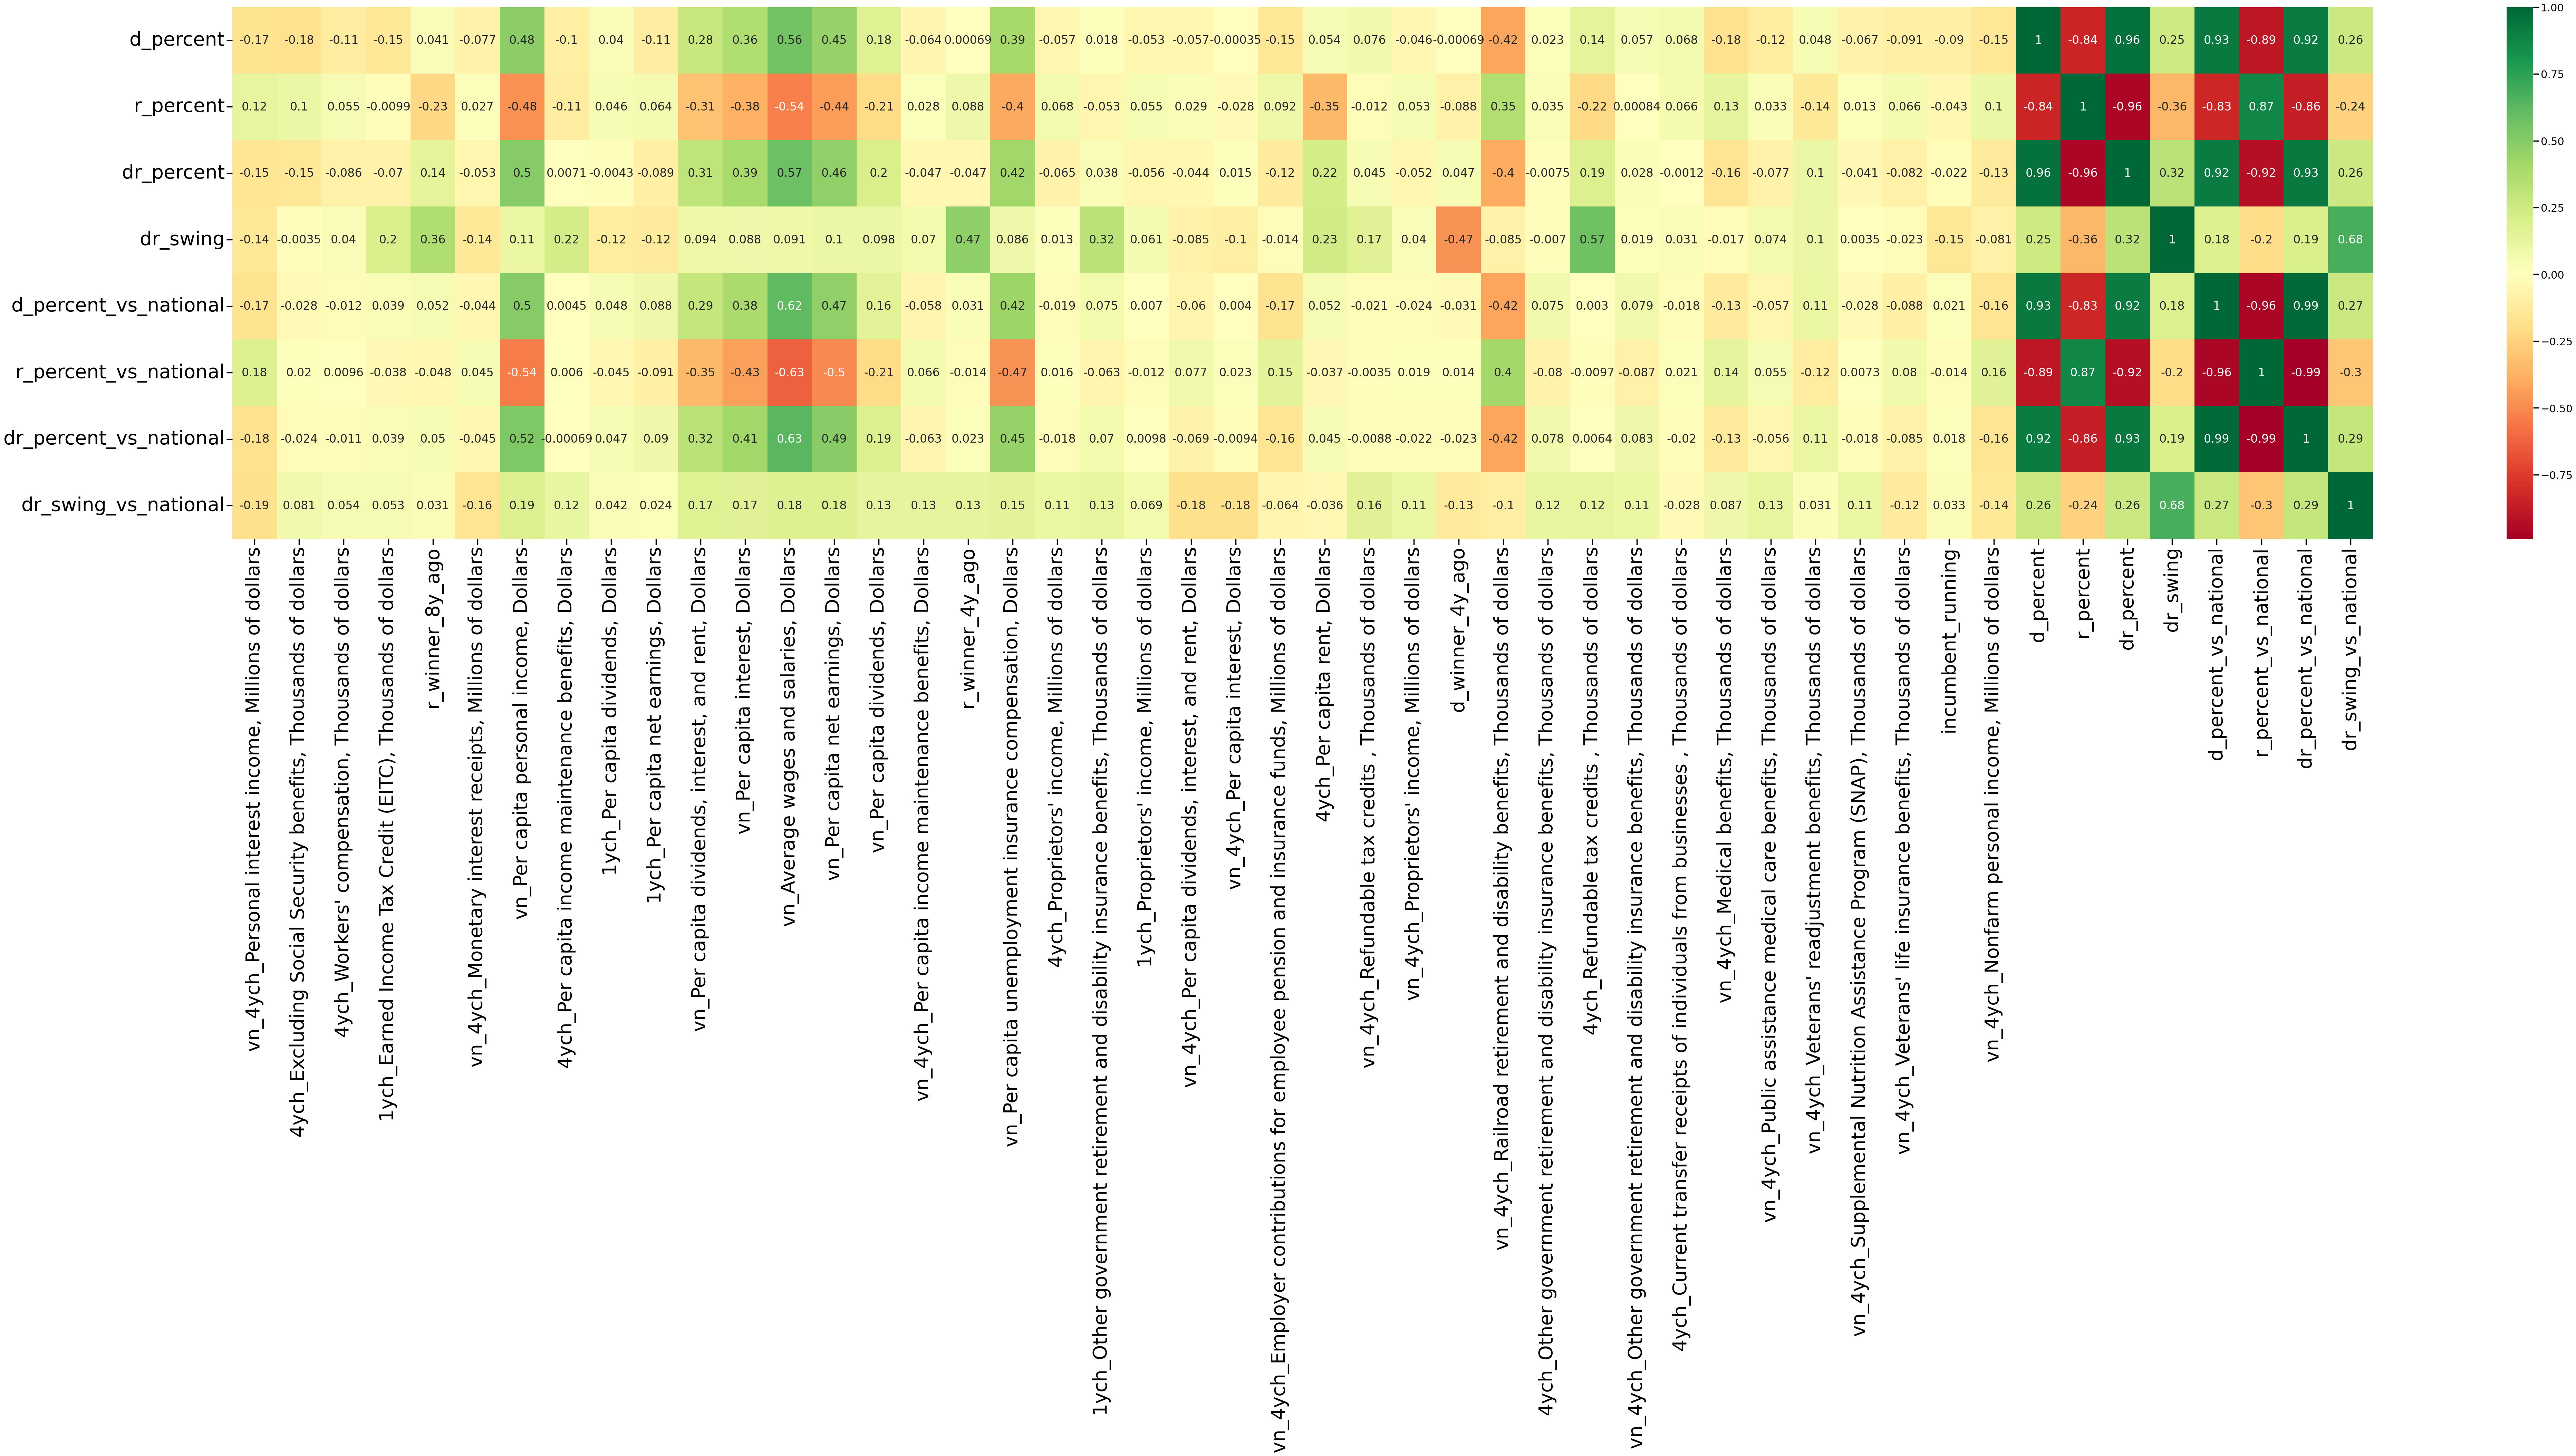

In [146]:
fig, ax = plt.subplots(figsize=(100,20))
sns.set_context('poster')
ax = sns.heatmap(df_heatmap.corr().iloc[-8:],annot=True,cmap='RdYlGn')
ax.set_xticklabels(df_heatmap.columns, fontsize=40)
ax.set_yticklabels(df_heatmap.columns[-8:], fontsize=40, rotation=0)
plt.show()
fig.savefig('heatmap.png', bbox_inches='tight')

The heatmap is difficult to read in the notebook, but possible while looking at the saved file in an image editor.

There are a few conclusions to be drawn from the heatmap:
1. There's a surprisingly strong correlation between the features showing the average wages and salaries and per capita net earnings versus national values and the election results. It shows a clear trend that wealthier states tend to vote for the Democratic party, and the poorer states - for the Republican party.
2. There is a moderate correlation between the value of per capita unemployment insurance compensation verusus national values and election results. But it's important not to confuse cause and effect: an explanation for this result would be that the states voting for the Democratic party in presidential elections tend to have the state governments largely controlled by the Democratic party, which would more likely add stronger social protections, including for the unemployed, to the state laws.
3. Overall, features showing the state value versus the national value, as opposed to just the the change in the state value overtime, are seen more among the selected features.
4. The manually added features showing the winners of the previous two national presidential elections and whether the incumbent president was running for the reelection clearly matter.
5. Some features have a low correlation coefficient with the targets on their own, but it doesn't mean they are not important - they could play a big role as a part of a polynomial feature that matters for the model.
6. The swing targets don't have a strong correlation with the other targets. They capture the change in the voting pattern rather that the voting pattern itself and correlate more with different features than the other targets.

# Overall conclusions and suggestions for future work

1. The main objective of the project was achieved: I was able to construct one fine-working model based on linear regression, extract and analyse the features that it uses, discovering some moderately strong correlations.
2. For almost every feature, Lasso has shown better results than Ridge, and plain linear regression didn't work in all cases. Lasso was also the type of the one fine-working model that I was able to construct. Therefore, Lasso is the best type of linear regression for performing feature selection.
3. However, the best model that I constructed predicted a target describing the political swing between the two parties, not the actual election results themselves. But, as was seen, the correlation between the swing and the actual election results is not strong. So in order to select features that could be used for predicting election results, it would be better to construct an adequate Lasso model predicting a target describing the actual results. While I failed to do so here, it probably can be achieved by adding more features and/or selective sampling - deselecting the outlier states heavily voting for one of the parties (such as Utah or District of Colombia) to decrease the skew of the targets.
4. Also, different Lasso models with slightly different hyperparameters close to the the optimal ones can be built and analysed, and only the features appearing across multiple models can be selected.
5. As for predicting the actual outcome of an election, more features are reqired, and perhaps it would be better to use methods other than linear regression, such as logistic regression. After all, in American politics it doesn't really matter what is the margin of your win in a state, as long as you win it.